<img src='otus.png'>

In [121]:
from __future__ import print_function
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib
import pandas_profiling
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from pandas_profiling import ProfileReport

%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 8)
pd.options.display.float_format = '{:.2f}'.format

In [122]:
fn = 'orders.csv'

In [123]:
!head $fn

DISCOUNT_VALUE,NAME,PRICE,QUANTITY,date_insert,discount,itemID,orderID,ordered_item_count,price,user_id
23.55%,Хроники Амбера. Том 2,357.0,1,2017-03-19 22:25:20,110.0,169108,602051,1,527.0,911531
4.07%,Хроники Амбера. Том 1,448.0,1,2017-03-19 22:19:58,19.0,1394744,602047,1,618.0,911531
4.17%,Пищеводитель,414.0,1,2017-03-19 20:58:00,65.0,191276,602017,4,1503.0,911587
4.17%,"Аудиокн. Мясников. &quot;Ржавчина&quot;: что делать, чтобы сердце не болело",253.0,1,2017-03-19 20:58:00,65.0,157945,602017,4,1503.0,911587
4.09%,Инфекции. Как защитить себя и своего ребенка,422.0,1,2017-03-19 20:58:00,65.0,205173,602017,4,1503.0,911587
4.17%,О самом главном с доктором Мясниковым,414.0,1,2017-03-19 20:58:00,65.0,189415,602017,4,1503.0,911587
4.12%,Пеппи Длинныйчулок собирается в путь,489.0,1,2017-03-19 20:53:51,42.0,168183,602015,2,1238.0,201724
4.12%,Пеппи Длинныйчулок в стране Веселии,489.0,1,2017-03-19 20:53:51,42.0,186112,602015,2,1238.0,201724
4.09%,Серебряный шар. Драма за сценой,586.0,1,2017-0

## Задача

* сегментация товаров + сегментация пользователей (по товарам, по поведению, скидкам и пр.)

# 1. Провести EDA
Просмотреть структуру данных, значения каждого признака, поискать особенности в признаках и в данных вцелом

Дополнительнительные задачи (опционально, подумайте о них, могут появиться интересные идеи и находки):
* поиск товаров-заменителей и товаров, дополняющих друг друга
* поиск выбросов среди товаров
* поиск выбросов среди заказов

# 2. Спланировать эксперимент 

Эксперимент - составить план, по которому будет проделана исследовательская работа. Примерные пункты плана:
* Составить первичный список признаков, необходимых для решения задачи
* Сгенерировать список новых признаков, которые можно получить из данных
* Применить кластеризацию
* Применить понижение размерности для визуализации данных (tsne, pca), визуализировать. Визуально оценить сопоставимость данных после снижения размерности и кластеров
* Описание кластера
* Любые другие пункты

# 3. Выполнить подготовку данных для построения модели

Выполнить необходимые преобразования данных

# 4. Провести построение модели 

# 5. Проанализировать результат
получилось или нет, почему, что можно улучшить, можно ли интерпретировать результат

# 6. Повторить при необходимости 

# Подсказки

* Проводить EDA и работу с признаками на всем датасете
* Для построения модели отсеивать данные тем или иным способом (обосновать выбор) - уменьшить объем данных для анализа
* Оформлять для сдачи задания все эксперименты (в том числе неудачные). Так мы сможем увидеть процесс работы над заданием
* Не тратить 90% времени на первый этап. Планировать время так, чтобы успеть поработать над моделью (в равной степени над каждым пунктом).

In [124]:
import warnings
warnings.filterwarnings('ignore')
sns.set_style('white')

# EDA

Наблюдения:
- Всего 557818 записей и 11 признаков
- Имена колонок - 2 блока разными регистрами, возможно, использовались различные источники данных 
- Есть пропущенные значения в 2 признаках
    - discount_value: 4041 пропущенных значения
    - name: 7 пропущенных значений
- Поле price есть в обоих блоках, возможно PRICE - стоимость данной позиции в чеке после применения скидки, а price - стоимость всего чека без скидок
- Наблюдается положительная корреляция между следующими признаками
    - quantity - order_price 
    - discount - order_price
    - discount - ordered_item_count
    - ordered_item_count - order_price

Идеи:
- Переименовать поле price в order_price
- Для удобства, перевести все названия колонок в нижний регистр

In [125]:
# Чтение данных и получении копии для исследования
data = pd.read_csv('./orders.csv', parse_dates=['date_insert'])
df = data.copy()
df.head()

DISCOUNT_VALUE                                               NAME  PRICE  \
0         23.55%                              Хроники Амбера. Том 2 357.00   
1          4.07%                              Хроники Амбера. Том 1 448.00   
2          4.17%                                       Пищеводитель 414.00   
3          4.17%  Аудиокн. Мясников. &quot;Ржавчина&quot;: что д... 253.00   
4          4.09%       Инфекции. Как защитить себя и своего ребенка 422.00   

   QUANTITY         date_insert  discount   itemID  orderID  \
0         1 2017-03-19 22:25:20    110.00   169108   602051   
1         1 2017-03-19 22:19:58     19.00  1394744   602047   
2         1 2017-03-19 20:58:00     65.00   191276   602017   
3         1 2017-03-19 20:58:00     65.00   157945   602017   
4         1 2017-03-19 20:58:00     65.00   205173   602017   

   ordered_item_count   price  user_id  
0                   1  527.00   911531  
1                   1  618.00   911531  
2                   4 1503.00   911587  
3                   4 1503.00   911587  
4                   4 1503.00   911587

In [126]:
# Переименование колонки и перевод названий колонок в нижний регистр 
df = df.rename(columns={'price': 'order_price'}).rename(columns=str.lower)
df.head()

discount_value                                               name  price  \
0         23.55%                              Хроники Амбера. Том 2 357.00   
1          4.07%                              Хроники Амбера. Том 1 448.00   
2          4.17%                                       Пищеводитель 414.00   
3          4.17%  Аудиокн. Мясников. &quot;Ржавчина&quot;: что д... 253.00   
4          4.09%       Инфекции. Как защитить себя и своего ребенка 422.00   

   quantity         date_insert  discount   itemid  orderid  \
0         1 2017-03-19 22:25:20    110.00   169108   602051   
1         1 2017-03-19 22:19:58     19.00  1394744   602047   
2         1 2017-03-19 20:58:00     65.00   191276   602017   
3         1 2017-03-19 20:58:00     65.00   157945   602017   
4         1 2017-03-19 20:58:00     65.00   205173   602017   

   ordered_item_count  order_price  user_id  
0                   1       527.00   911531  
1                   1       618.00   911531  
2                   4      1503.00   911587  
3                   4      1503.00   911587  
4                   4      1503.00   911587

In [127]:
# Общая информации о данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 557818 entries, 0 to 557817
Data columns (total 11 columns):
discount_value        553777 non-null object
name                  557811 non-null object
price                 557818 non-null float64
quantity              557818 non-null int64
date_insert           557818 non-null datetime64[ns]
discount              557818 non-null float64
itemid                557818 non-null int64
orderid               557818 non-null int64
ordered_item_count    557818 non-null int64
order_price           557818 non-null float64
user_id               557818 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(5), object(2)
memory usage: 46.8+ MB


In [128]:
# Статистика для все типов колонок
df.describe(include='all')

discount_value                                               name  \
count          553777                                             557811   
unique           2551                                              74632   
top                 0  Пока-я-не-Я. Практическое руководство по транс...   
freq            30502                                                940   
first             NaN                                                NaN   
last              NaN                                                NaN   
mean              NaN                                                NaN   
std               NaN                                                NaN   
min               NaN                                                NaN   
25%               NaN                                                NaN   
50%               NaN                                                NaN   
75%               NaN                                                NaN   
max               NaN                                                NaN   

           price  quantity          date_insert  discount     itemid  \
count  557818.00 557818.00               557818 557818.00  557818.00   
unique       nan       nan               126956       nan        nan   
top          nan       nan  2017-04-24 12:29:46       nan        nan   
freq         nan       nan                  277       nan        nan   
first        nan       nan  2017-03-13 00:05:06       nan        nan   
last         nan       nan  2017-10-01 23:50:02       nan        nan   
mean      242.73      1.65                  NaN    519.41  562126.66   
std       261.93      5.05                  NaN   1032.42  557123.66   
min         0.00      1.00                  NaN  -1963.00  131823.00   
25%        92.00      1.00                  NaN    175.00  178533.00   
50%       185.74      1.00                  NaN    313.00  196485.00   
75%       313.00      1.00                  NaN    537.00  727802.00   
max     19792.18    500.00                  NaN  23851.00 1787508.00   

         orderid  ordered_item_count  order_price   user_id  
count  557818.00           557818.00    557818.00 557818.00  
unique       nan                 nan          nan       nan  
top          nan                 nan          nan       nan  
freq         nan                 nan          nan       nan  
first        nan                 nan          nan       nan  
last         nan                 nan          nan       nan  
mean   662756.84               12.15      2797.27 641006.11  
std     37746.44               19.61      7586.23 386439.17  
min    597731.00                1.00         1.00      3.00  
25%    630532.00                4.00      1053.00 194865.00  
50%    662686.00                7.00      1389.00 911644.00  
75%    694208.00               13.00      2276.40 948489.00  
max    730392.00              277.00    386495.00 998104.00

In [129]:
# Количество пропущенных значений
df.isnull().sum()

discount_value        4041
name                     7
price                    0
quantity                 0
date_insert              0
discount                 0
itemid                   0
orderid                  0
ordered_item_count       0
order_price              0
user_id                  0
dtype: int64

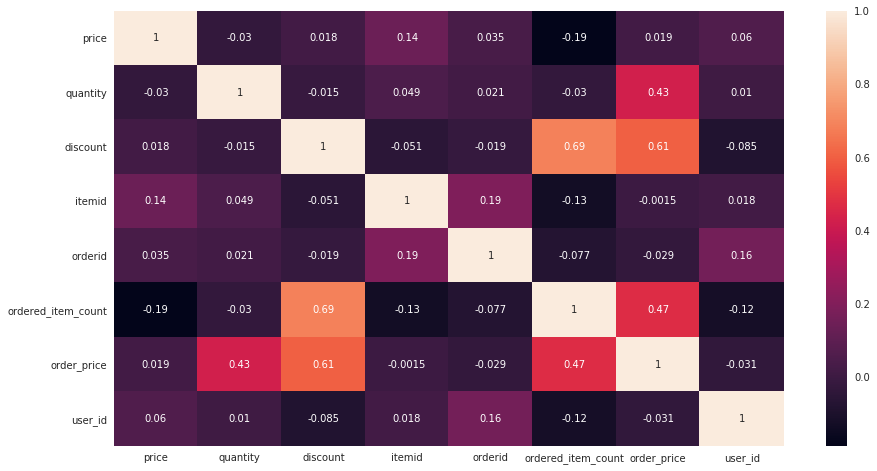

In [130]:
# Heatmap с корреляцией признаков
sns.heatmap(df.corr(), annot=True)

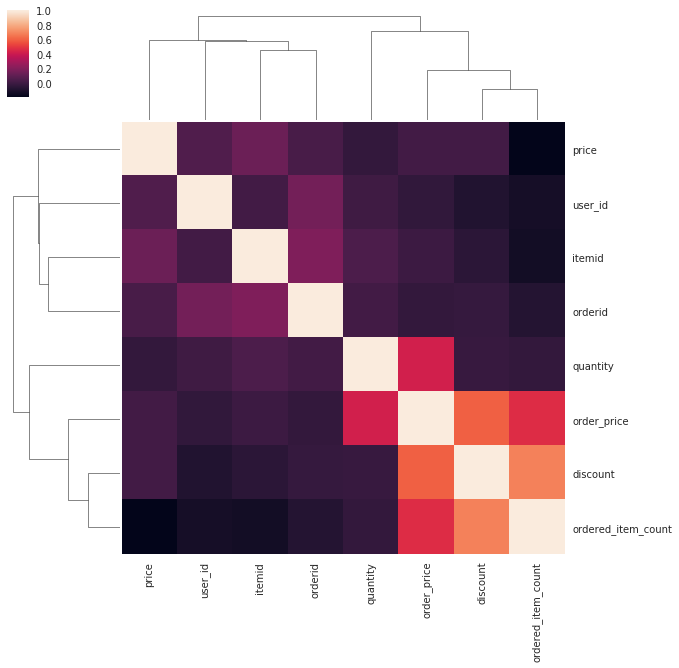

In [131]:
# Heatmap c применением иерархической кластеризации для значеинй корреляции между признаками
sns.clustermap(df.corr())

#### discount_value

Описание:
- Значение скидки в процентах
- Количественный непрерывный признак

Наблюдения:
- Значения указаны со знаком процента
- Значения могут быть с десятичными знаками
- Есть пропущенные значения (4041)
- Следующие равенство не выполняется строго:
    - price * discount_value = discount
- Существуют позиции с очень большими скидками

Идеи:
- Парсинг значений (удаление не цифровых символов)
- Преобразование в float64
- Выбрать один с способов обработки пропущенных значений
    - Удаление строк с пропущенными значениями
    - Среднее/медиана
- Нормализация
- Признаки
    - discount_value - преобразованное значение скидки
    - discount_category - категория скидок (разбиение на bins)

In [132]:
# Удаление нечисловых символов и преобразование в числовое значение (доля суммы скидки)
df['discount_value'] = df['discount_value'].str.replace('%', '').astype(np.float64) / 100
df[['discount_value']].describe()

discount_value
count       553777.00
mean             0.18
std              0.11
min              0.00
25%              0.08
50%              0.20
75%              0.24
max              0.94

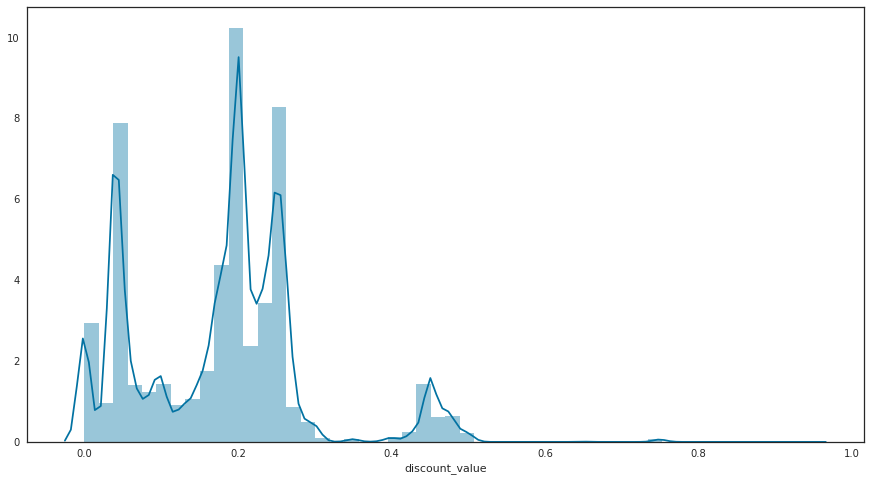

In [133]:
# Распределение значений
sns.distplot(df['discount_value'].dropna())

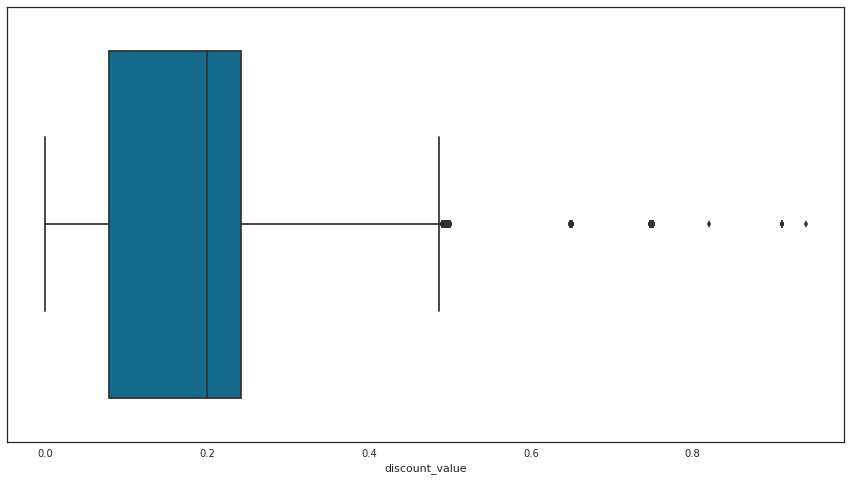

In [134]:
# Возможные выбросы среди значений
sns.boxplot('discount_value', data=df)

#### Name

Описание:
- Наименование товара
- Номинальный признак

Наблюдения:

- Есть пропущенные значения (7)
- Всего 74632 уникальный наименований товаров
- В названии используются скобки для различных целей
    - Как часть названия
    - Как доп. информация (цвет, вес, доп. характеристики и т.д.)
    
Идеи:
- Выбрать один из способов обработки пропущенных значений
    - Удалить строки
    - Заполнить значением "unknown"
    - Заполнить наименованием товаров, наиболее похожим по другим характеристикам 
- Парсинг наименований 
    - Информация в скобках (вес, цвет и т.д.)
- Возможные признаки
    - Наименование после удаления информации о весе
    - Доп. информация из названия как отдельный признак (например, вес)
    - Обработка признака как текстового (например, bag of words + tf-idf)

In [135]:
# Общая статистика
df[['name']].describe()

name
count                                              557811
unique                                              74632
top     Пока-я-не-Я. Практическое руководство по транс...
freq                                                  940

In [136]:
# Наименования товаров, где присутствует текст в скобках
df['name'].iloc[np.where(df['name'].str.extract('(\(.*\))$').notnull())].sample(20).values

array(['Английский язык. 7 класс. Рабочая тетрадь (с тестовыми заданиями ЕГЭ)',
       'Атлас мира. Максимально подробная информация (бел.)',
       'Уничтожь меня! Уникальный блокнот для творческих людей (космическое оформление)',
       'Английский язык. 5 класс. Рабочая тетрадь (с тестовыми заданиями ОГЭ)',
       'Все сказки (вес: 175гр.)',
       'Пир стервятников (новая картинка) (вес: 545гр.)',
       'Математика. 2 класс. Контрольные и диагностические работы (вес: 47гр.)',
       'Китайский язык. 6 класс. Рабочая тетрадь (вес: 164гр.)',
       'Работы по дереву. Иллюстрированная энциклопедия (вес: 1340гр.)',
       'На Западном фронте без перемен (вес: 152гр.)',
       'Инкассатор. Всадники апокалипсиса (вес: 273гр.)',
       'Реальный самоучитель английского языка. Начальный уровень (+CD)',
       'Политическая карта мира. Физическая карта мира NG (A1)',
       'Радиант Пильмана: Предел желания (вес: 325гр.)',
       'Высокая мода. Для юных модельеров и модниц (вес: 260гр.)',


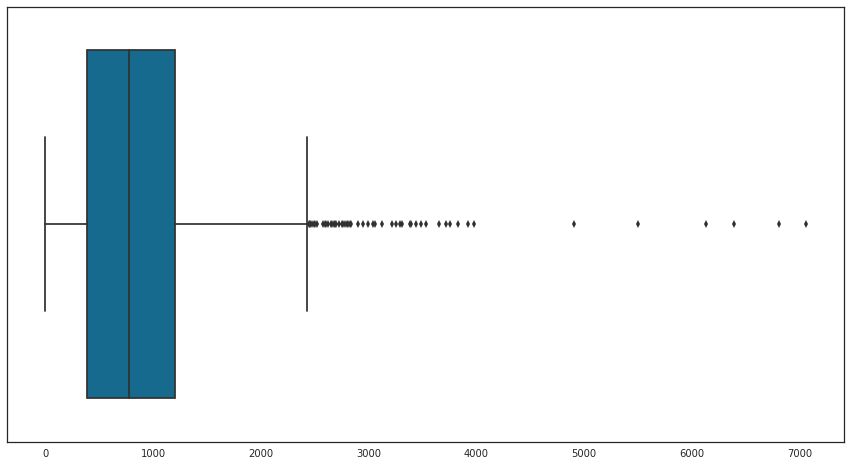

In [137]:
# Распределение веса товара (где он указан в наименовании)
sns.boxplot(df['name'].str.extract('\(вес:\s*(\d+).*гр.\)\s*$').dropna().unique().astype(int))

#### price

Описание:
- Цена одной единицы товара в позиции после применения скидок
- Количественная непрерывная переменная

Наблюдения:
- Есть записи с нулевым значением
- Существуют позиции с очень маленькими и большими значениями цены (относительно медианы)

Идеи:
- Нормализация
- Признаки
    - Цена
    - Категория цены (разбиение на bins)

In [138]:
# Общая статистика
df[['price']].describe()

price
count 557818.00
mean     242.73
std      261.93
min        0.00
25%       92.00
50%      185.74
75%      313.00
max    19792.18

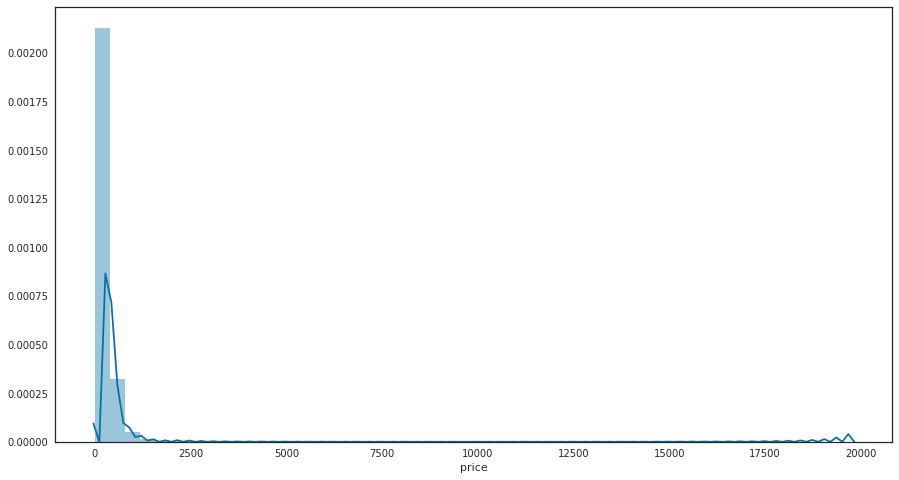

In [139]:
# Распределение цены
sns.distplot(df['price'])

In [140]:
# Наиболее частая стоимость товаров в позициях
df.groupby('price')['price'].count().sort_values(ascending=False).head(10)

price
1.00      10831
150.00     7563
52.00      7163
62.00      5237
43.00      5141
41.00      5021
49.00      4075
65.00      3842
50.00      3733
54.00      2908
Name: price, dtype: int64

In [141]:
# Позиции, где стоимость товара равно 1 (самой частой стоимости)
df[df['price'] == 1].head()

discount_value                              name  price  quantity  \
426            0.04        Бемби (ил. М. Митрофанова)   1.00         1   
440            0.15                            Марина   1.00         1   
453            0.06      Пароль: &quot;вечность&quot;   1.00         1   
459            0.05  Winx Club. Наклей и прочитай №11   1.00         1   
460            0.05  Winx Club. Наклей и прочитай №10   1.00         1   

            date_insert  discount  itemid  orderid  ordered_item_count  \
426 2017-03-16 23:59:20    300.00  161799   600632                   4   
440 2017-03-16 22:49:37    352.00  183484   600581                   4   
453 2017-03-16 21:21:00     53.00  175434   600525                   4   
459 2017-03-16 21:03:49     84.00  184482   600509                   8   
460 2017-03-16 21:03:49     84.00  184662   600509                   8   

     order_price  user_id  
426      1084.00   910026  
440      1099.00   910440  
453       408.00   910411  
459      1795.00   901365  
460      1795.00   901365

#### quantity

Описание:
- Кол-во единиц товара в позиции
- Количественный дискретный признак

Наблюдения:
- Есть позиции с очень большим кол-вом единиц товара (относительного медианы)
- Большая часть позиций содержит не более 3 товаров (около 97%)

Идеи:
- Нормализация
- Признаки 
    - Общее кол-во товаров по чеку
    - Разбиение на bins (1, 2, 3, other)

In [142]:
# Общая статистика
df[['quantity']].describe()

quantity
count 557818.00
mean       1.65
std        5.05
min        1.00
25%        1.00
50%        1.00
75%        1.00
max      500.00

In [143]:
# Распределение количества товара в одной позиции
(df.groupby('quantity')['quantity'].count() / len(df)).head()

quantity
1   0.93
2   0.03
3   0.01
4   0.00
5   0.00
Name: quantity, dtype: float64

#### date_insert

Описание:
- Дата внесения записи в БД

Наблюдения:
- Данные по продажам были внесены в период с 2017-03-13 по 2017-10-01
- Кол-во товаров, проданных в рабочие дни, больше продаж в выходные дни
- Наблюдается тренд в увеличении кол-ва проданных товаров за указанный период времени

Идеи:
- Возможные признаки
    - Месяц, день недели, день месяца, час
    - Выходной или нет

In [144]:
# Общая статистика
df[['date_insert']].describe()

date_insert
count                557818
unique               126956
top     2017-04-24 12:29:46
freq                    277
first   2017-03-13 00:05:06
last    2017-10-01 23:50:02

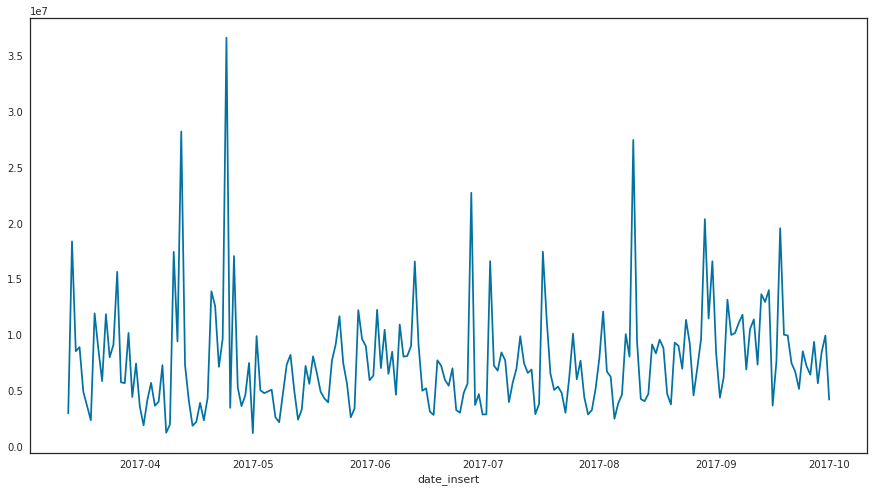

In [145]:
# Распределение суммарных продаж по дням
df.groupby(df.date_insert.dt.date)['order_price'].sum().plot.line()

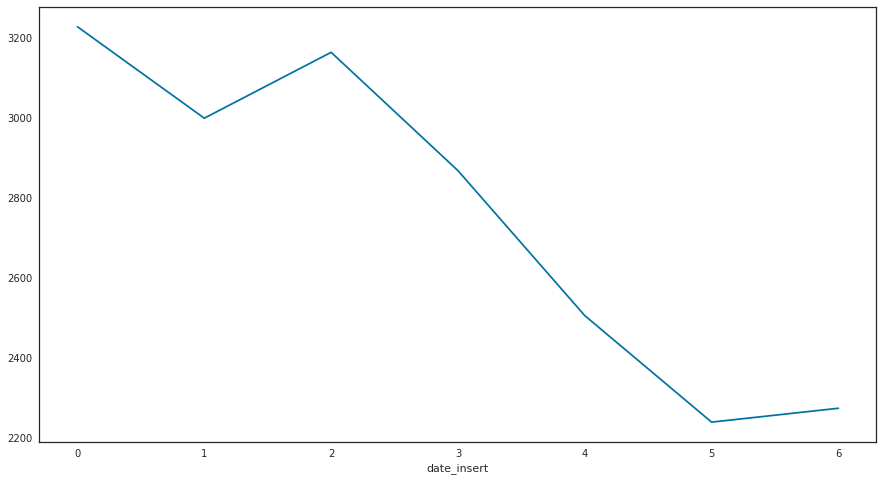

In [146]:
# Распределение средней стоимости чека по дням недели
df.groupby(df.date_insert.dt.weekday)['order_price'].mean().plot.line()

#### discount

Описание:
- Сумма скидки по чеку
- Количественный непрерывный признак

Наблюдения:
- Существуют отрицательные значения скидки (297 записей)

Идеи:
- Нормализация
- Удалить строки с отрицательными значениями скидки

In [147]:
# Общая статистика
df[['discount']].describe()

discount
count 557818.00
mean     519.41
std     1032.42
min    -1963.00
25%      175.00
50%      313.00
75%      537.00
max    23851.00

In [148]:
# Позиции с отрицательным значением скидки
df.iloc[np.where(df['discount'] < 0)].head()

discount_value                                               name  price  \
83              nan                    История государства Российского 777.00   
84              nan  100 любимых стихов и 100 любимых сказок для ма... 500.00   
190             nan  Кыш, Двапортфеля и целая неделя. Кыш и я в Кры... 437.00   
191             nan  В Стране Вечных Каникул. Саша и Шура (вес: 640... 386.00   
376             nan       Первый учебник малыша. От 6 месяцев до 3 лет 376.00   

     quantity         date_insert  discount  itemid  orderid  \
83          1 2017-03-19 03:21:08  -1277.00  196964   601703   
84          1 2017-03-19 03:21:08  -1277.00  191129   601703   
190         1 2017-03-18 11:15:09   -823.00  198440   601300   
191         1 2017-03-18 11:15:09   -823.00  200733   601300   
376         1 2017-03-17 10:15:09   -564.00  204137   600758   

     ordered_item_count  order_price  user_id  
83                    2      1556.00   195867  
84                    2      1556.00   195867  
190                   2      1102.00   910987  
191                   2      1102.00   910987  
376                   2       843.00   910569

In [149]:
# Кол-во позиций с отрицательным значением скидки
df.loc[df['discount'] < 0].shape

(294, 11)

#### itemid

Описание:
- Идентификатор товара
- Номинальный признак

Наблюдения:
- Есть товары с одинаковым наименованием, но с разными itemid
    - Возможно, менялся id товара со временем?
- Есть товары с одинаковым itemid, но с разными наименованиями
    - Указан вес
    - Переработанное издание
    - Наличие доп. пробелов в наименовании
    - Измененное наименование книги
    - Другие причины?
- Значения itemid имеют 3-4 диапазона значений
    - При использовании 2х первых цифр itemid для категории (получение первого символа как строкового признака) - явного разбиения товаров по категориям товаров не обнаружено
    - При использовании нескольких первых цифр itemid для категории (деление на 10000 как числового признака) - явного разбиения товаров по категориям товаров не обнаружено

Идеи:
- Не использовать признак

In [150]:
# Общая статистика
df['itemid'].astype('category').describe()

count      557818
unique      51890
top       1641209
freq          989
Name: itemid, dtype: int64

In [151]:
# Датасет с уникальной парой name-itemid
unique_df = df.dropna().drop_duplicates(['name', 'itemid'])
unique_df.shape

(82167, 11)

In [152]:
# Количество уникальных наименований и идентификаторов позиций в полученном датасете
unique_df['name'].unique().size, unique_df['itemid'].unique().size

(74473, 51777)

In [153]:
# Товары с одинаковым наименованием, но разными идентификаторами позиций
unique_df.loc[unique_df.duplicated('name', keep=False)].sort_values('name')[['name', 'itemid']].head(20).values

array([['#Selfmama. Лайфхаки для работающей мамы', 1443198],
       ['#Selfmama. Лайфхаки для работающей мамы', 710320],
       ['&quot;Коламбия пикчерз&quot; представляет', 150137],
       ['&quot;Коламбия пикчерз&quot; представляет', 214556],
       ['&quot;Спартак&quot; - наше всё. Откровения кумира красно-белых',
        160512],
       ['&quot;Спартак&quot; - наше всё. Откровения кумира красно-белых',
        163725],
       [ '&quot;Спартак&quot; - наше всё. Откровения кумира красно-белых (вес: 562гр.)',
        163725],
       [ '&quot;Спартак&quot; - наше всё. Откровения кумира красно-белых (вес: 562гр.)',
        160512],
       ['10 мифов Древней Руси. Анти-Бушков, анти-Задорнов, анти-Прозоров',
        596657],
       ['10 мифов Древней Руси. Анти-Бушков, анти-Задорнов, анти-Прозоров',
        667608],
       ['100 картинок', 1412551],
       ['100 картинок', 1445119],
       ['100 лет активной жизни, или Секреты здорового долголетия', 190722],
       ['100 лет активной жизн

In [154]:
# Кол-во уникальных itemid и дублей 
unique_df['itemid'].unique().size, unique_df['itemid'].duplicated().sum()

(51777, 30390)

In [155]:
# Товары с одинаковым идентификатором позиции, но разными названиями
unique_df.loc[unique_df.duplicated('itemid', keep=False)].sort_values('itemid')[['name', 'itemid']].head(20).values

array([[ 'Рисуем по клеточкам и точкам. Многоразовая тетрадь для мальчиков (вес: 30гр.)',
        131823],
       ['Рисуем по клеточкам и точкам. Многоразовая тетрадь для мальчиков',
        131823],
       ['Ты, только ты', 132034],
       ['Ты, только ты (вес: 180гр.)', 132034],
       [ 'Мастер звонка. Как объяснять, убеждать, продавать по телефону. 2-е изд. (вес: 507гр.)',
        132062],
       ['Мастер звонка. Как объяснять, убеждать, продавать по телефону. 2-е изд.',
        132062],
       ['Дневник молодой мамы', 132111],
       ['Дневник молодой мамы (вес: 526гр.)', 132111],
       ['Бижутерия из бисера (вес: 66гр.)', 132303],
       ['Бижутерия из бисера', 132303],
       ['Грибной царь', 132342],
       ['Грибной царь (вес: 435гр.)', 132342],
       ['Боевой расчет', 132401],
       ['Боевой расчет (вес: 300гр.)', 132401],
       ['Учим буквы: для детей 3-4 лет (вес: 60гр.)', 132413],
       ['Учим буквы: для детей 3-4 лет', 132413],
       ['Любимые забавы папы Карло (вес

In [156]:
# Кол-во уникальных наименованй в оригинальном датасете
unique_df['name'].unique().size, unique_df['name'].duplicated().sum()

(74473, 7694)

In [157]:
# Удалим из наименований информацию о весе (если она присутствует),
# для уменьшения кол-ва уникальных наименований продуктов
unique_df['name'] = unique_df['name'].str.replace('(\s*\(вес:\s*.*\))', '')

In [158]:
# Преобразованные наименования товаров с одинаковым идентификатором позиции, но разными названиями
unique_df.loc[unique_df.duplicated('itemid', keep=False)].sort_values('itemid')[['name', 'itemid']].head(20).values

array([['Рисуем по клеточкам и точкам. Многоразовая тетрадь для мальчиков',
        131823],
       ['Рисуем по клеточкам и точкам. Многоразовая тетрадь для мальчиков',
        131823],
       ['Ты, только ты', 132034],
       ['Ты, только ты', 132034],
       ['Мастер звонка. Как объяснять, убеждать, продавать по телефону. 2-е изд.',
        132062],
       ['Мастер звонка. Как объяснять, убеждать, продавать по телефону. 2-е изд.',
        132062],
       ['Дневник молодой мамы', 132111],
       ['Дневник молодой мамы', 132111],
       ['Бижутерия из бисера', 132303],
       ['Бижутерия из бисера', 132303],
       ['Грибной царь', 132342],
       ['Грибной царь', 132342],
       ['Боевой расчет', 132401],
       ['Боевой расчет', 132401],
       ['Учим буквы: для детей 3-4 лет', 132413],
       ['Учим буквы: для детей 3-4 лет', 132413],
       ['Любимые забавы папы Карло', 132445],
       ['Любимые забавы папы Карло', 132445],
       ['Григорий Распутин: правда и ложь', 132487],
     

In [159]:
# Кол-во уникальных наименований и дублей после их преобразования
unique_df['name'].unique().size, unique_df['name'].duplicated().sum()

(44804, 37363)

In [160]:
# Повторное удаление записей с дублями пар name-itemid
unique_df = unique_df.dropna().drop_duplicates(['name', 'itemid'])
unique_df.shape

(52732, 11)

In [161]:
# Кол-во уникальных наименований и дублей после их преобразования
unique_df['name'].unique().size, unique_df['name'].duplicated().sum()

(44804, 7928)

In [162]:
# Кол-во уникальных itemid и дублей 
unique_df['itemid'].unique().size, unique_df['itemid'].duplicated().sum()

(51777, 955)

In [163]:
# Товары с одинаковым наименованием, но разными идентификаторами позиций
unique_df.loc[unique_df.duplicated('name', keep=False)].sort_values('name')[['name', 'itemid']].head(20).values

array([['#Selfmama. Лайфхаки для работающей мамы', 710320],
       ['#Selfmama. Лайфхаки для работающей мамы', 1443198],
       ['&quot;Коламбия пикчерз&quot; представляет', 150137],
       ['&quot;Коламбия пикчерз&quot; представляет', 214556],
       ['&quot;Спартак&quot; - наше всё. Откровения кумира красно-белых',
        163725],
       ['&quot;Спартак&quot; - наше всё. Откровения кумира красно-белых',
        160512],
       ['10 мифов Древней Руси. Анти-Бушков, анти-Задорнов, анти-Прозоров',
        596657],
       ['10 мифов Древней Руси. Анти-Бушков, анти-Задорнов, анти-Прозоров',
        667608],
       ['100 картинок', 1445119],
       ['100 картинок', 1412551],
       ['100 лет активной жизни, или Секреты здорового долголетия', 190360],
       ['100 лет активной жизни, или Секреты здорового долголетия', 190722],
       [ '100 лучших ракет СССР и России. Первая энциклопедия отечественной ракетной техники',
        193242],
       [ '100 лучших ракет СССР и России. Первая энци

In [164]:
# Товары с одинаковым идентификатором позиции, но разными названиями
unique_df.loc[unique_df.duplicated('itemid', keep=False)].sort_values('itemid')[['name', 'itemid']].head(20).values

array([['Подвиги Геракла', 132877],
       ['Подвиги Геракла (ил. Г. Мацыгина)', 132877],
       ['Тропические растения.Удивительная флора жарких стран', 136131],
       ['Тропические растения. Удивительная флора жарких стран', 136131],
       ['Русский язык.3 кл. Учебник. Ч.1, Ч.2. Комплект.', 140411],
       ['Русский язык. 3 класс. Учебник в 2-х частях. Комплект.', 140411],
       ['Необычная аппликация. 5-7 лет. Рабочая тетрадь', 143323],
       ['Необычная аппликация. Рабочая тетрадь.', 143323],
       ['Аппликация. Подумай и дополни. 3–4 года. Пособие для детей',
        144331],
       [ 'Аппликация. Подумай и дополни. 3–4 года. Пособие для детей (переработанное)',
        144331],
       ['Три толстяка', 144771],
       ['Три толстяка (ил. И. Петелиной)', 144771],
       ['Герой иного времени', 144810],
       ['Герой иного времени в супере', 144810],
       [ 'Аппликация. Выбери и приклей. 2–3 года. Пособие для детей (переработанное)',
        144873],
       ['Аппликация. Выб

In [165]:
# Возьмем случайную выборку из данных
sample_df = df.sample(5000)

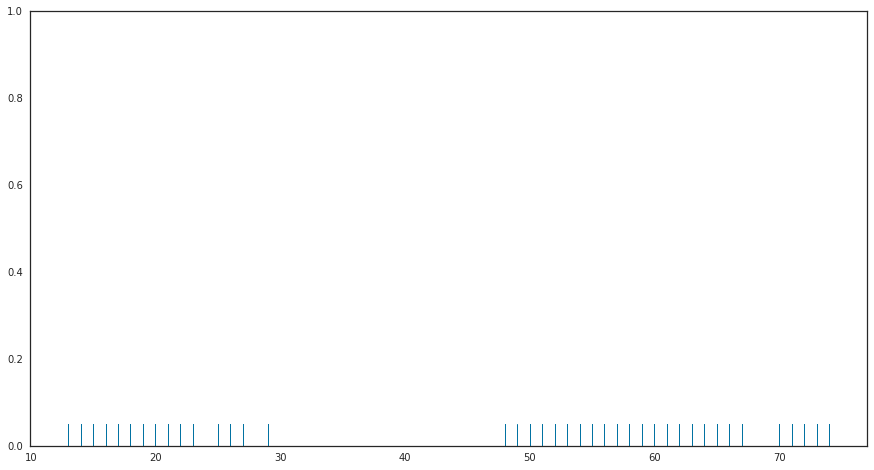

In [166]:
# Проверим возможность разбиения на категории, если взять первые 2 символа из признака как строки
item_str_cat = pd.DataFrame(sample_df['itemid'].astype(str).str[:2].astype(int))
sns.rugplot(item_str_cat)

In [167]:
# Закодируем категории в 2 значения (для точек разбиения [10, 40, 80])
item_str_cat_codes = pd.cut(item_str_cat.values.ravel(), [10, 40, 80]).codes
item_str_cat_codes

array([0, 0, 1, ..., 0, 0, 0], dtype=int8)

In [168]:
# Первые 5 строк из каждой категории
sample_df.groupby(item_str_cat_codes).head(5).sort_values('itemid')

discount_value                                               name  \
417584            0.27                   Прописи с развивающими заданиями   
262980            0.00  Новейший иллюстрированный справочник комнатных...   
57182             0.15  История России. 7 класс. Технологические карты...   
538481            0.16     Энциклопедия доктора Мясникова о самом главном   
279855            0.21  Angry birds. Большая зеленая книга креативных ...   
412251            0.26            География. 7 класс. Атлас (вес: 132гр.)   
305573            0.21  Сутажная вышивка. Элегантные украшения своими ...   
46265             0.22                       Python для детей и родителей   
256363            0.13           Математика. 1 класс. Рабочая тетрадь №1.   
533019            0.45  Крайон. Деньги — это энергия! Научитесь ею упр...   

        price  quantity         date_insert  discount   itemid  orderid  \
417584  38.00         2 2017-08-27 10:35:58    343.00   135697   694873   
262980  60.59         1 2017-06-30 17:40:14    921.40   180432   659301   
57182  127.00         1 2017-03-29 20:13:42    620.00   184151   609404   
538481 635.00         1 2017-09-27 18:36:12    551.00   187010   726852   
279855  34.40         1 2017-07-06 17:53:36    273.40   534876   662531   
412251 106.00        27 2017-08-21 13:38:26    102.00   637327   690450   
305573 434.00         1 2017-07-15 19:41:20    267.00   711077   668023   
46265  561.00         1 2017-03-20 14:04:12    339.00   713764   602478   
256363 177.00         3 2017-06-27 13:41:43    162.00   732352   657670   
533019 127.00         1 2017-09-24 08:27:41    269.00  1629781   723279   

        ordered_item_count  order_price  user_id  
417584                  14      1640.00   241715  
262980                  27      4984.98   924330  
57182                   20      2987.00   173372  
538481                   9      3731.00   995933  
279855                  45      1508.00   896604  
412251                   4      7884.00   940713  
305573                   3      1125.00   925026  
46265                    2      1201.00    88676  
256363                   7      3771.00   948385  
533019                   4       327.00   194728

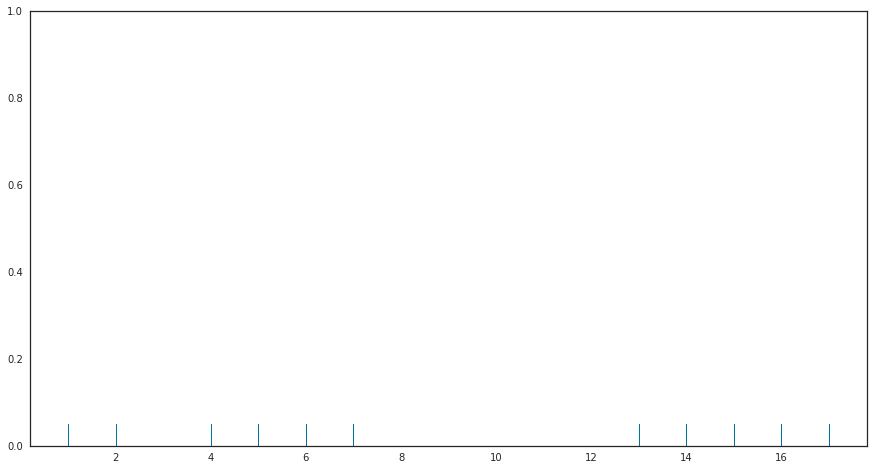

In [169]:
# Проверим возможность разбиения на категории, если поделить значение признака как числа на 1000000
item_num_cat = pd.DataFrame(sample_df['itemid'] // 100000)
sns.rugplot(item_num_cat)

In [170]:
# Закодируем категории в 2 значения (для точек разбиения [0, 3, 10, 20])
item_num_cat_codes = pd.cut(item_num_cat.values.ravel(), [0, 3, 10, 20]).codes
item_num_cat_codes

array([0, 2, 1, ..., 0, 0, 2], dtype=int8)

In [171]:
# Первые 5 строк из каждой категории
sample_df.groupby(item_num_cat_codes).head(5).sort_values('itemid')

discount_value                                               name  \
417584            0.27                   Прописи с развивающими заданиями   
262980            0.00  Новейший иллюстрированный справочник комнатных...   
57182             0.15  История России. 7 класс. Технологические карты...   
538481            0.16     Энциклопедия доктора Мясникова о самом главном   
133874            0.06  Энциклопедия обучения ребенка раннего возраста...   
279855            0.21  Angry birds. Большая зеленая книга креативных ...   
412251            0.26            География. 7 класс. Атлас (вес: 132гр.)   
305573            0.21  Сутажная вышивка. Элегантные украшения своими ...   
46265             0.22                       Python для детей и родителей   
256363            0.13           Математика. 1 класс. Рабочая тетрадь №1.   
264579            0.24                                       Сентрал-парк   
92807             0.25                                      Дым и зеркала   
533019            0.45  Крайон. Деньги — это энергия! Научитесь ею упр...   
492925            0.04  ЕГЭ. Итоговое сочинение перед единым государст...   
456455            0.10  В мире чисел и цифр. 5-7 лет. Учебно-методичес...   

        price  quantity         date_insert  discount   itemid  orderid  \
417584  38.00         2 2017-08-27 10:35:58    343.00   135697   694873   
262980  60.59         1 2017-06-30 17:40:14    921.40   180432   659301   
57182  127.00         1 2017-03-29 20:13:42    620.00   184151   609404   
538481 635.00         1 2017-09-27 18:36:12    551.00   187010   726852   
133874 589.00         1 2017-05-12 11:08:11    178.00   190651   631200   
279855  34.40         1 2017-07-06 17:53:36    273.40   534876   662531   
412251 106.00        27 2017-08-21 13:38:26    102.00   637327   690450   
305573 434.00         1 2017-07-15 19:41:20    267.00   711077   668023   
46265  561.00         1 2017-03-20 14:04:12    339.00   713764   602478   
256363 177.00         3 2017-06-27 13:41:43    162.00   732352   657670   
264579 109.00         1 2017-06-27 17:27:34    279.00  1433706   657797   
92807  147.00         1 2017-04-20 18:29:39    476.00  1581176   620177   
533019 127.00         1 2017-09-24 08:27:41    269.00  1629781   723279   
492925   1.00         1 2017-09-13 15:20:03    246.00  1634229   712347   
456455 201.00         3 2017-09-04 12:20:19    158.00  1653510   702193   

        ordered_item_count  order_price  user_id  
417584                  14      1640.00   241715  
262980                  27      4984.98   924330  
57182                   20      2987.00   173372  
538481                   9      3731.00   995933  
133874                   4      1119.00   185461  
279855                  45      1508.00   896604  
412251                   4      7884.00   940713  
305573                   3      1125.00   925026  
46265                    2      1201.00    88676  
256363                   7      3771.00   948385  
264579                   9      1047.00   948464  
92807                    6      1432.00   924536  
533019                   4       327.00   194728  
492925                  12      2703.14   986179  
456455                   3      4422.00   946195

#### orderid

Описание:
- Идентификатор чека
- Номинальный признак

Наблюдения:
- Значения имеют непрерывную последовательность (нет выраженных диапазонов)

Идеи:
- Не использовать данный признак отдельно
- Использовать данный признак для группировки данных по чекам

In [172]:
# Общая статистика
df[['orderid']].describe()

orderid
count 557818.00
mean  662756.84
std    37746.44
min   597731.00
25%   630532.00
50%   662686.00
75%   694208.00
max   730392.00

In [173]:
# Чеки с наибольшим количеством позиций
df['orderid'].value_counts()[:10]

623226    277
616630    243
610887    214
658214    211
706752    208
607954    206
674731    199
682271    184
598513    174
672204    158
Name: orderid, dtype: int64

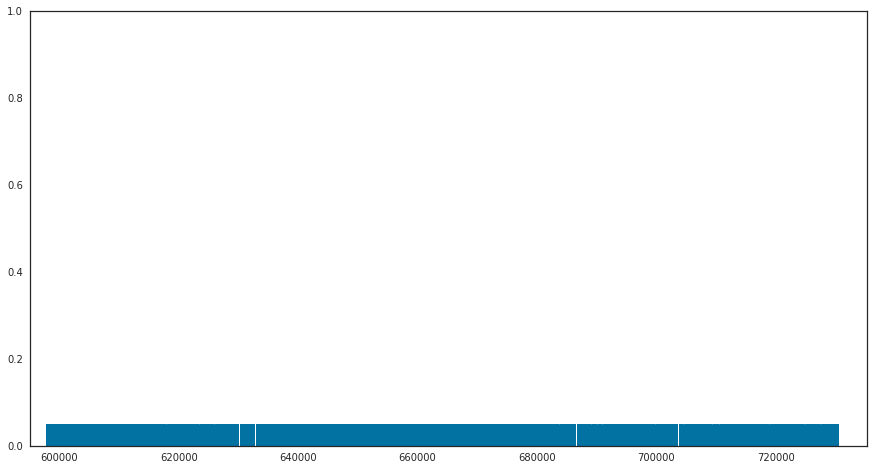

In [174]:
# Распределение значений на случайной выборке
sns.rugplot(df['orderid'].sample(5000))

#### ordered_item_count

Описание:
- Кол-во позиций в чеке
- Количественный дискретный признак

Наблюдения:
- Чаще всего в чеке 4 позиции

Идеи:
- Преобразовать в bins для категорий (выбросы - в отдельную категорию)

In [175]:
# Общая статистика
df[['ordered_item_count']].describe()

ordered_item_count
count           557818.00
mean                12.15
std                 19.61
min                  1.00
25%                  4.00
50%                  7.00
75%                 13.00
max                277.00

In [176]:
# Кол-во уникальных значений
df['ordered_item_count'].unique().size

127

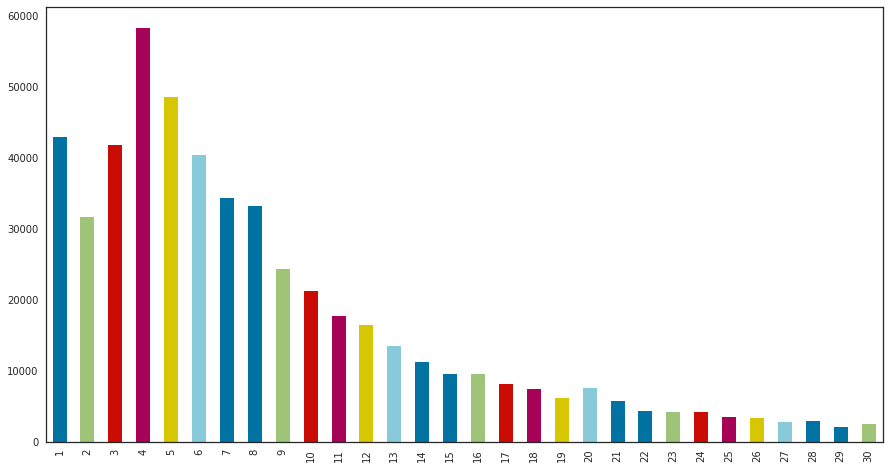

In [177]:
# Распределение кол-ва позиций в чеке
df['ordered_item_count'].value_counts().sort_index()[:30].plot.bar()

#### order_price

Описание:
- Общая стоимость чека
- Количественный непрерывный признак

Наблюдения:
- Чаще всего стоимость чека - около 1000 рублей

Идеи:
- Преобразовать значения в bins (диапазоны цен)

In [178]:
# Общая статистика
df[['order_price']].describe()

order_price
count    557818.00
mean       2797.27
std        7586.23
min           1.00
25%        1053.00
50%        1389.00
75%        2276.40
max      386495.00

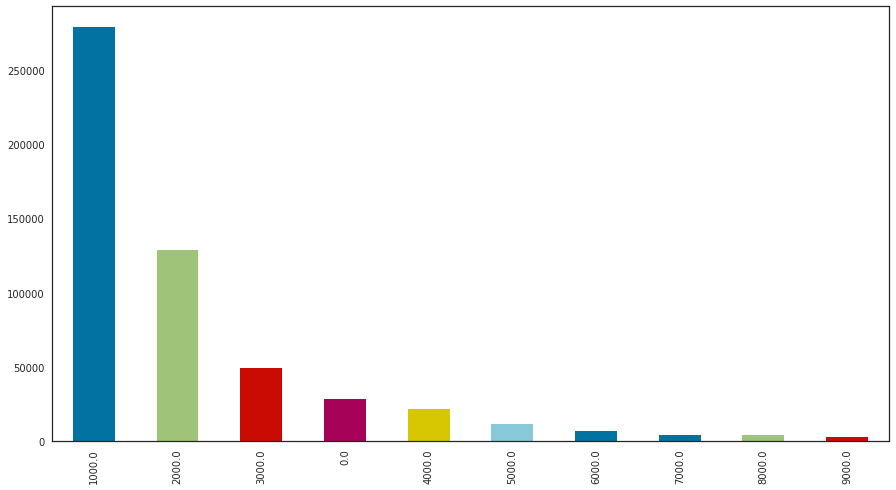

In [179]:
# Распределение стоимости чеков, округленной до тысяч
df['order_price'].apply(lambda x: np.round(x, -3)).value_counts().iloc[:10].plot.bar()

#### user_id

Описание:
- Идентификатор покупателя
- Номинальный признак

Наблюдения:
- Явной структуры в значениях не обнаружено

Идеи:
- Не использовать данный признак отдельно

In [180]:
# Общая статистика
df[['user_id']].describe()

user_id
count 557818.00
mean  641006.11
std   386439.17
min        3.00
25%   194865.00
50%   911644.00
75%   948489.00
max   998104.00

In [181]:
# Кол-во уникальных клиентов
df['user_id'].unique().size

76258

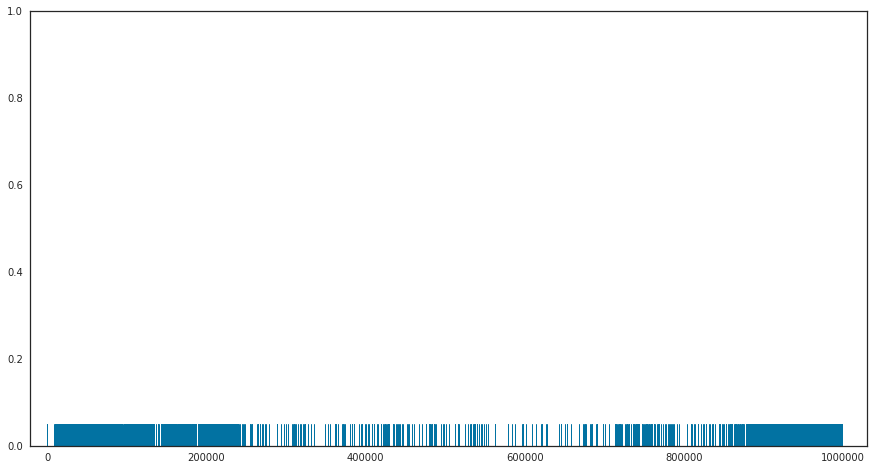

In [182]:
# Распределение идентификаторов пользователей
sns.rugplot(df['user_id'].sample(5000))

# План эксперимента

- Рассмотреть задачу 3 типов сегментации
    - По позициям чека
    - По пользователям
    - По продуктам
- Для каждого из типов сегментации
    - Сделать случайную выборку записей для дальнейшей обработки (в данном случае - 5000 записей)
    - Выбрать признаки из существующих, и при необходимости, сгенерировать дополнительные признаки
    - Преобразовать признаки для дальнейшей кластеризации и понижения размерности
    - Применить кластеризацию к преобразованному датасету
        - AgglomerativeClustering
        - KMeans
        - DBSCAN
    - Применить понижение размерности к преобразованному датасету
        - PCA
        - TSNE
    - Построить визуализацию полученных кластеров, с использованием 2 компонент как результата понижения размерности
    - Произвести визуальную оценку полученных кластеров
    - Определить основные характеристики для полученных кластеров
    - Сделать выводы по результатам сегментации

# Сегментация по позициям чеков

## Выбор и преобразование признаков

- price
    - Нормализовать
- quantity
    - Нормализовать
- discount
    - Нормализовать
- ordered_item_count
    - Нормализовать
- order_price
    - Нормализовать

In [183]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN, MiniBatchKMeans
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.manifold import TSNE, MDS
from sklearn.model_selection import ParameterGrid
from sklearn.neighbors import NearestNeighbors

from yellowbrick.cluster import SilhouetteVisualizer

from IPython.display import display, HTML

In [184]:
# Transformer для получения необходимых признаков
class ColumnExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.columns]

In [185]:
# Transformer для получения случайной подвыборки
class RandomSampler(BaseEstimator, TransformerMixin):
    def __init__(self, samples_num=5000, random_state=None):
        self.samples_num = samples_num
        self.random_state = random_state
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return pd.DataFrame(X).sample(n=self.samples_num, random_state=self.random_state)

In [186]:
# Transformer для конвертации numpy-массива в DataFrame с именованными колонками
class DataFrameConverter(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return pd.DataFrame(X, columns=self.columns)

In [187]:
# Transformer для генерации меток кластера, для возможности использования в pipeline 
# как промежуточного шага
class ClusterLabelGenerator(BaseEstimator, TransformerMixin):
    def __init__(self, estimator, **kwargs):
        self.estimator = estimator
        self.kwargs = kwargs

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return self.estimator(**self.kwargs).fit_predict(X).reshape(-1, 1)

In [188]:
# Установка параметров
columns = ['price', 'discount', 'ordered_item_count', 'order_price', 'quantity']
cluster_label = 'cluster_id'
sample_size = 5000
random_state = 42
k = 4

In [189]:
# Обработка параметров
proc_pipeline = Pipeline([
    ('sample', RandomSampler(samples_num=sample_size, random_state=random_state)),
    ('preprocessing', Pipeline([
        ('extract', ColumnExtractor(columns=columns)),
        ('normalize', RobustScaler()),
    ]))
])

# Понижение размерности
dim_red_pipeline = Pipeline([
    ('dim_reduction', PCA(random_state=random_state))   
])

# Кластеризация
cluster_pipeline = Pipeline([
    ('clustering', DBSCAN(min_samples=k))
])

In [190]:
# Преобразование выбранных признаков
processed_data = proc_pipeline.fit_transform(df)

## Кластеризация и понижение размерности

In [191]:
# Кластеризация (DBSCAN) 
cluster_params = {'clustering': DBSCAN(),
                  'clustering__min_samples': 4}
cluster_pipeline.set_params(**cluster_params)

cluster_labels = cluster_pipeline.fit_predict(processed_data)
cluster_model = cluster_pipeline.named_steps['clustering']
print(cluster_model)

DBSCAN(algorithm='auto', eps=0.5, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=4, n_jobs=1, p=None)


[311.08739682808078,
 231.65253867812507,
 221.54637312902824,
 123.0761383254473,
 41.014322974764404,
 31.960376274066149,
 31.960376274066149,
 31.946746363055521,
 31.946746363055521,
 28.579899514097281]

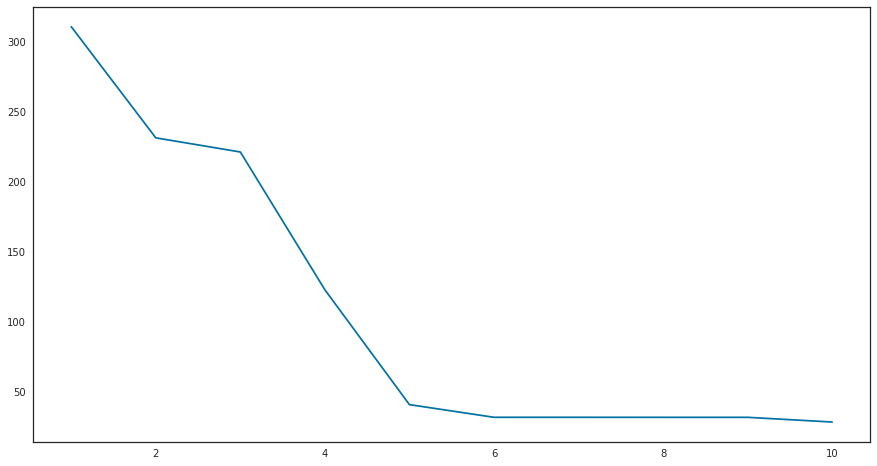

In [192]:
# Определение eps и min_pts для DBSCAN с помощью эвристики
nn = NearestNeighbors(n_neighbors=k).fit(processed_data)
distances, indices = nn.kneighbors(processed_data)
k_sorted_distances = sorted(distances[:,k-1], reverse=True)
plt.plot(np.arange(10) + 1, k_sorted_distances[:10])
k_sorted_distances[:10]

In [193]:
# Кластеризация на основе найденных параметров (eps = 32, min_pts = 6)
cluster_params = {'clustering': DBSCAN(),
                  'clustering__eps': 32,
                  'clustering__min_samples': 6}
cluster_pipeline.set_params(**cluster_params)

cluster_labels = cluster_pipeline.fit_predict(processed_data)
cluster_model = cluster_pipeline.named_steps['clustering']
print(cluster_model)

DBSCAN(algorithm='auto', eps=32, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=6, n_jobs=1, p=None)


In [194]:
# Понижение размерности (PCA)
dim_red_params = {'dim_reduction': PCA(),
                  'dim_reduction__random_state': random_state}
dim_red_pipeline.set_params(**dim_red_params)

pca_data = dim_red_pipeline.fit_transform(processed_data)
pca_columns = ['comp_' + str(i+1) for i in range(pca_data.shape[1])]
pca_data = pd.DataFrame(pca_data, columns=pca_columns)
pca_data[cluster_label] = cluster_labels

pca_model = dim_red_pipeline.named_steps['dim_reduction']
print(pca_model)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=42,
  svd_solver='auto', tol=0.0, whiten=False)


[ 0.70922172  0.93746353  0.97921011  0.99282016  1.        ]


price  discount  ordered_item_count  order_price  quantity
comp_1   0.00      0.07                0.04         0.62      0.78
comp_2   0.00     -0.36               -0.22        -0.69      0.59
comp_3   0.08     -0.70               -0.57         0.37     -0.20
comp_4   0.50      0.56               -0.66        -0.05      0.03
comp_5   0.86     -0.25                0.44        -0.00      0.00

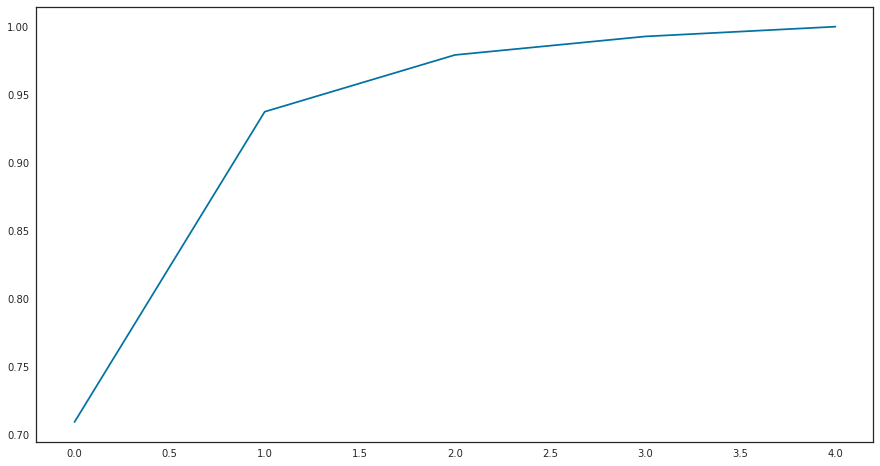

In [195]:
# Вывод объясненной дисперсии относительно первых n pca-компонент
print(pca_model.explained_variance_ratio_.cumsum())
plt.plot(pca_model.explained_variance_ratio_.cumsum())

# Определение коэффициентов для pca-компонент, на основе начальных признаков
pd.DataFrame(pca_model.components_, columns=columns, index=pca_columns)

In [196]:
# Понижение размерности (TSNE)
params = {'dim_reduction': TSNE(random_state=random_state)}
dim_red_pipeline.set_params(**params)

tsne_data = dim_red_pipeline.fit_transform(processed_data)
tsne_columns = ['comp_' + str(i+1) for i in range(tsne_data.shape[1])]
tsne_data = pd.DataFrame(tsne_data, columns=tsne_columns)
tsne_data[cluster_label] = cluster_labels

tsne_model = dim_red_pipeline.named_steps['dim_reduction']
print(tsne_model)

TSNE(angle=0.5, early_exaggeration=12.0, init='random', learning_rate=200.0,
   method='barnes_hut', metric='euclidean', min_grad_norm=1e-07,
   n_components=2, n_iter=1000, n_iter_without_progress=300,
   perplexity=30.0, random_state=42, verbose=0)


## Визуализация и описание кластеров

In [197]:
# Вывод позиций для каждого из полученных кластеров
cluster_df = df.sample(n=sample_size, random_state=random_state)
cluster_df[cluster_label] = cluster_labels
cluster_df.groupby(cluster_label).head(3).sort_values(cluster_label)

discount_value                                               name  \
371069            0.22                                Идиот (вес: 677гр.)   
118187            0.29  Последнее танго. Петр Лещенко. Все, что было.....   
325021            0.17  Сам себе пивовар. Первая пивная книга от росси...   
506561            0.23      1111 удивительных фактов, которых вы не знали   
375720            0.26            Годовой курс занятий: для детей 2-3 лет   
323220            0.08                                           Свет дня   

        price  quantity         date_insert  discount   itemid  orderid  \
371069 271.00         2 2017-08-10 09:53:20  13446.00   199345   682271   
118187  46.00         1 2017-04-24 12:29:46  23851.00   163815   623226   
325021 609.60        79 2017-07-24 16:35:51    419.00   162903   672898   
506561 184.00         1 2017-09-18 22:30:03    300.00  1644019   718078   
375720 344.00         1 2017-08-08 11:41:58    338.00   196879   680498   
323220 374.00         1 2017-07-23 13:03:40    885.00  1623452   672304   

        ordered_item_count  order_price  user_id  cluster_id  
371069                 184    117845.00   963473          -1  
118187                 277    114671.00   896089          -1  
325021                   3    203918.40   148794          -1  
506561                   4      1053.38   944615           0  
375720                   3      1774.00   723969           0  
323220                  10      1581.00   145853           0

In [198]:
# Средние значения оригинальных признаков в разрезе кластеров
cluster_df.groupby(cluster_label)[columns].mean()

price  discount  ordered_item_count  order_price  quantity
cluster_id                                                            
-1         276.47   9482.75              119.88    160730.55    117.12
 0         240.75    483.55               11.85      2500.73      1.55

In [199]:
cluster_df[cluster_label].value_counts().sort_index()

-1       8
 0    4992
Name: cluster_id, dtype: int64

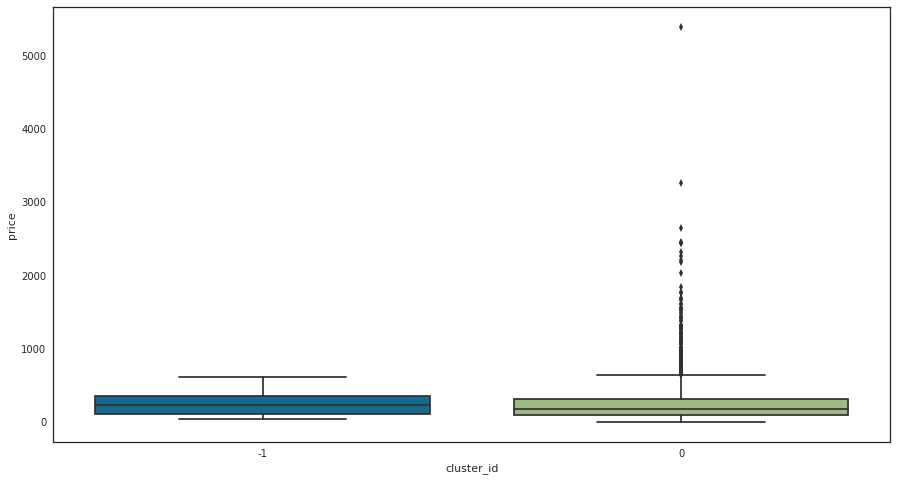

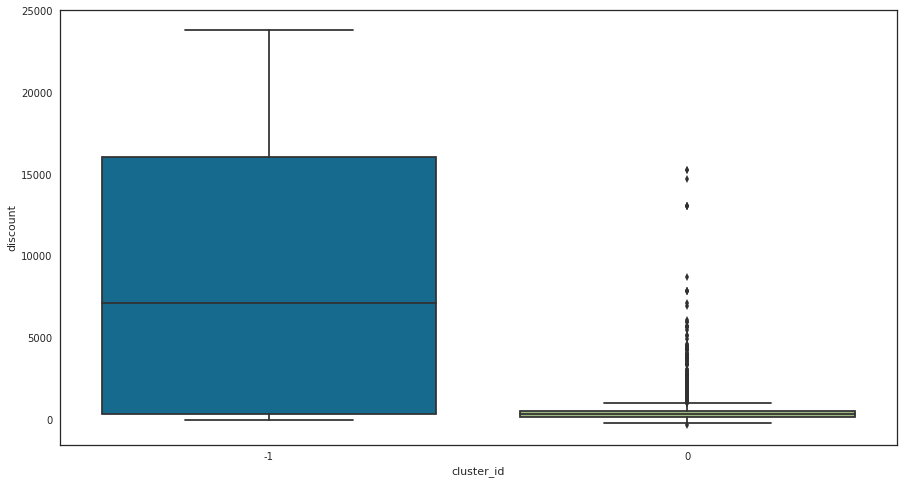

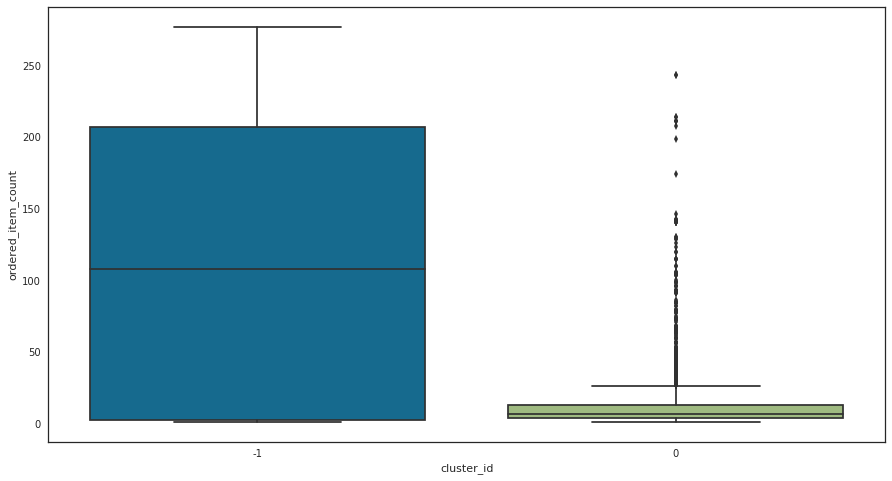

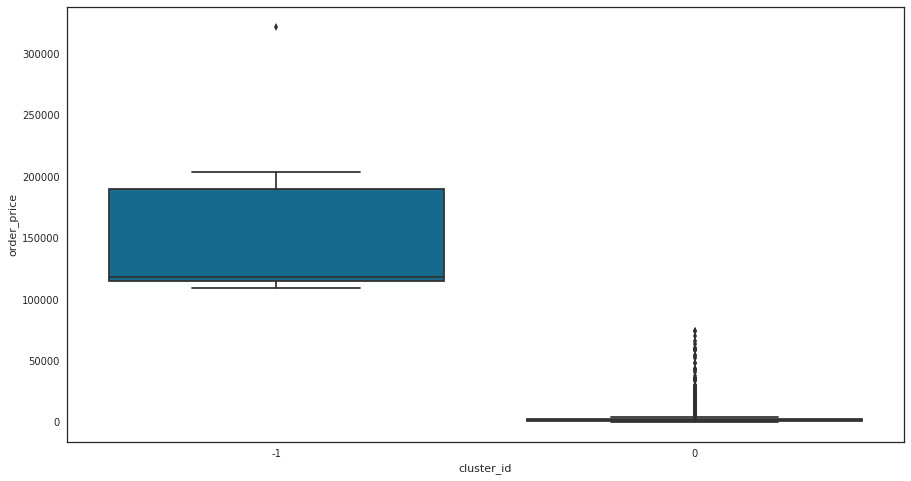

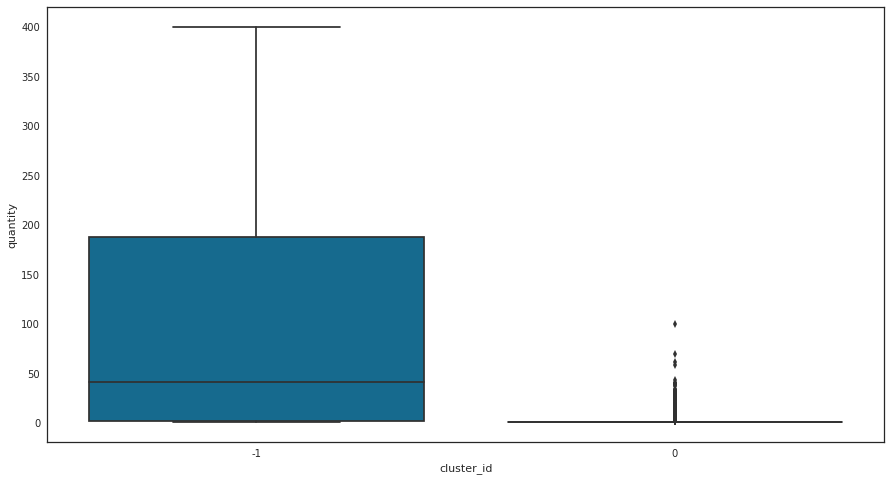

In [200]:
for col in columns:
    sns.boxplot(cluster_label, col, data=cluster_df)
    plt.show()

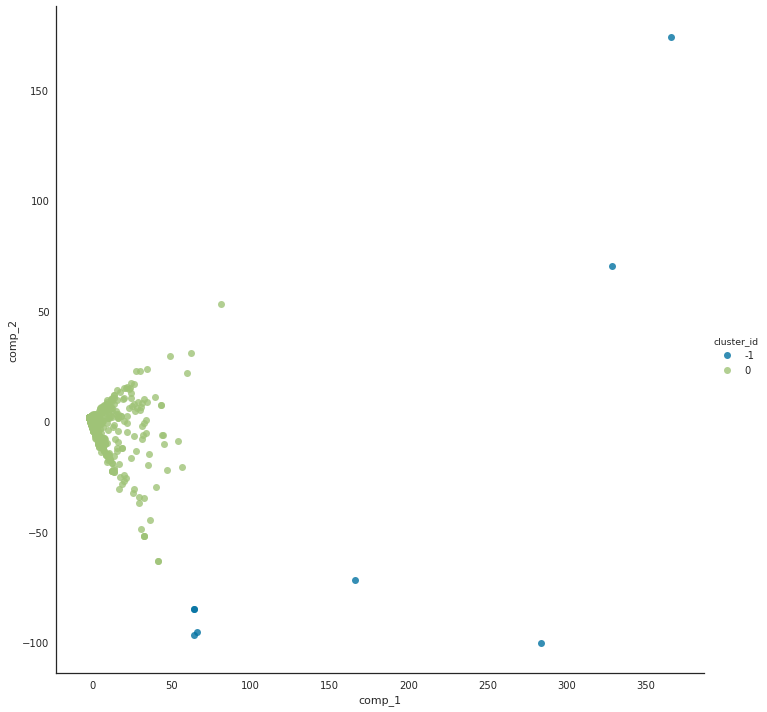

In [201]:
# Визуализация первых 2х pca-компонент
sns.lmplot('comp_1', 'comp_2', data=pca_data, hue=cluster_label, fit_reg=False, size=10)

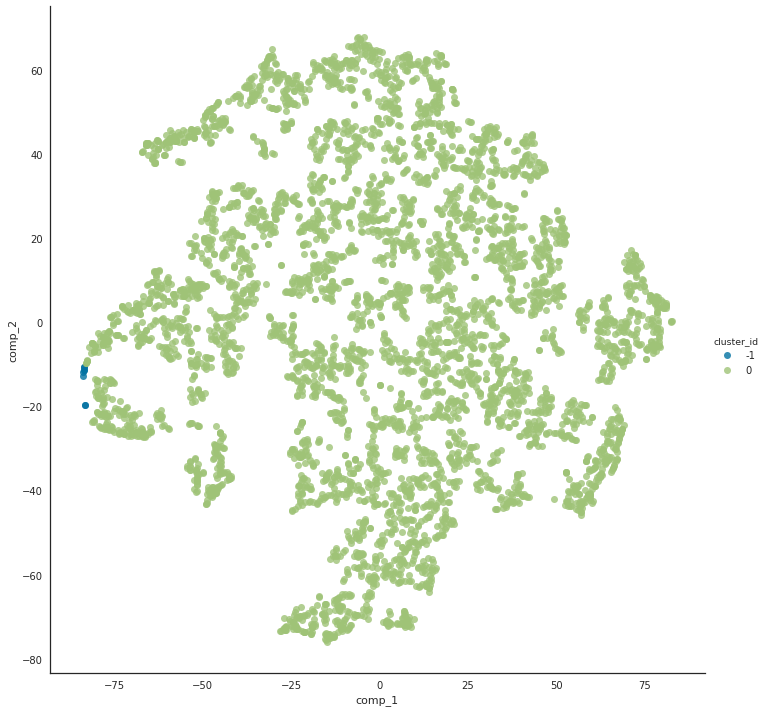

In [202]:
# Отобразим результаты кластеризации
sns.lmplot('comp_1', 'comp_2', data=tsne_data, hue=cluster_label, fit_reg=False, size=10)

**Выводы**  
Как можно увидеть, в кластере -1 ("шум" в терминологии DBSCAN) попали только несколько позиций чеков, у которых среднее значение всех признаков (кроме price) в среднем больше, чем в кластере 0.  
Таким образом, мы выделили несколько очень больших покупок (как по стоимости чека, так и по количеству купленных товаров)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=2,
            pooling_func='deprecated')


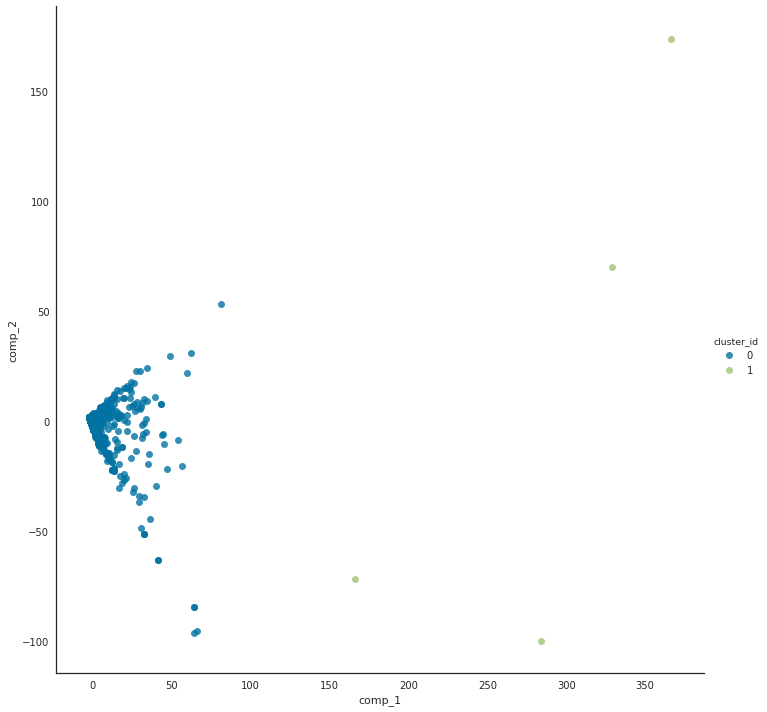

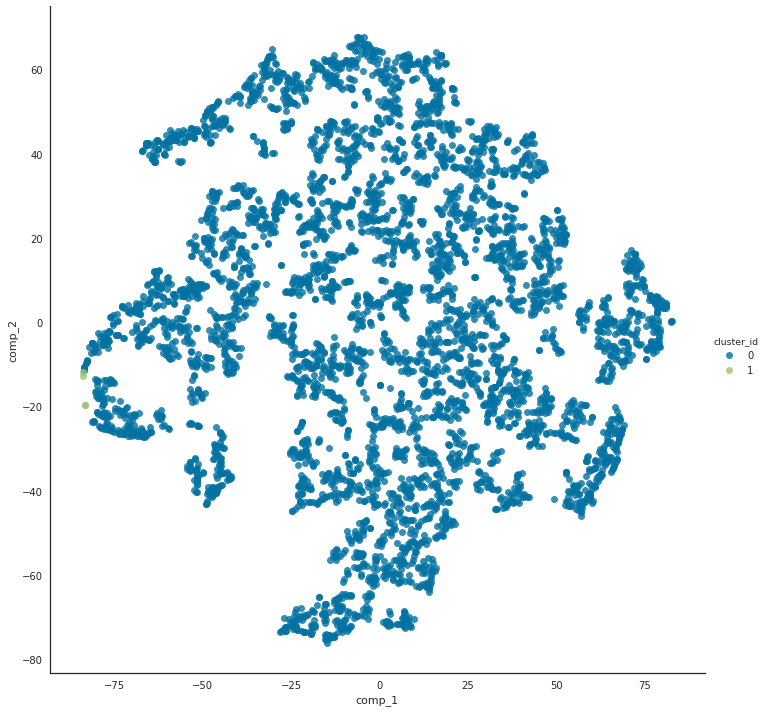

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=4,
            pooling_func='deprecated')


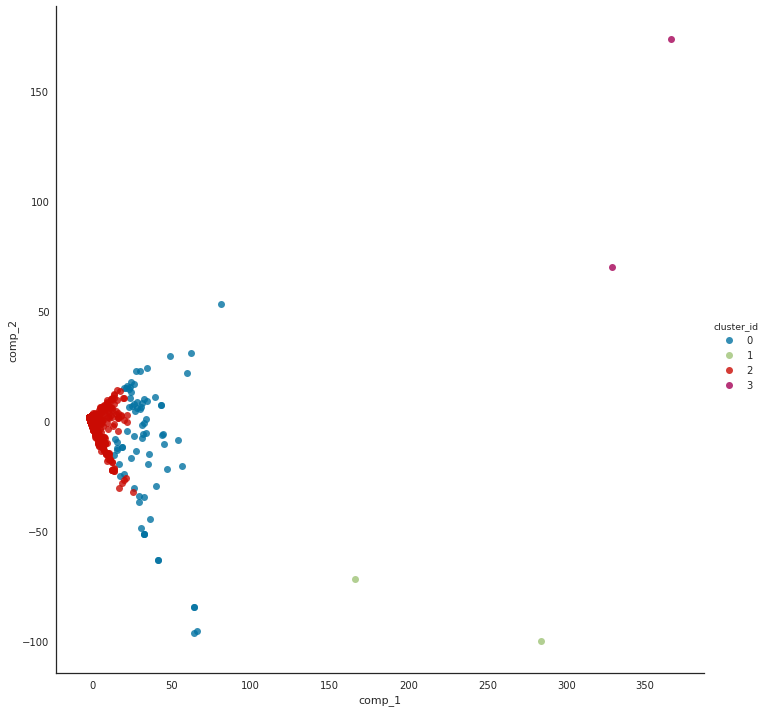

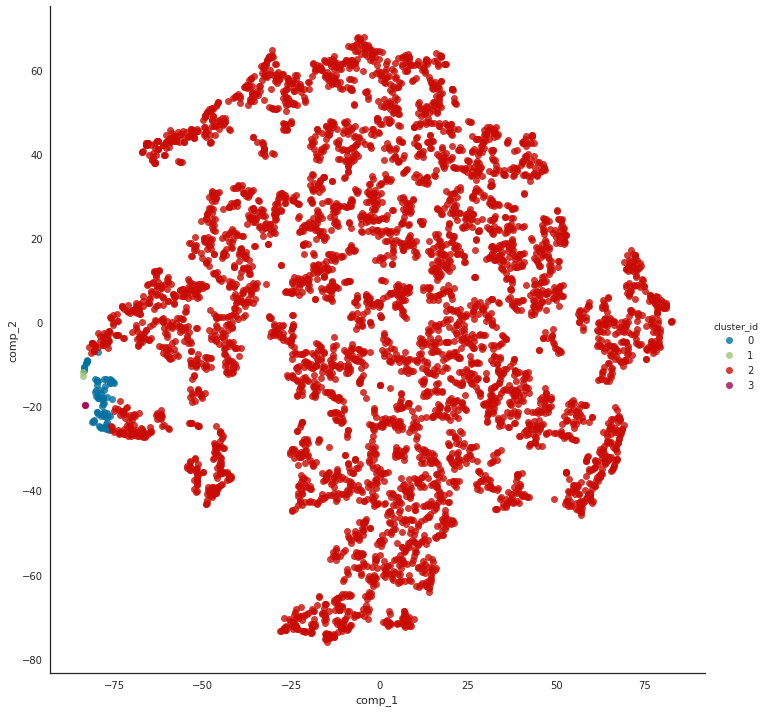

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=6,
            pooling_func='deprecated')


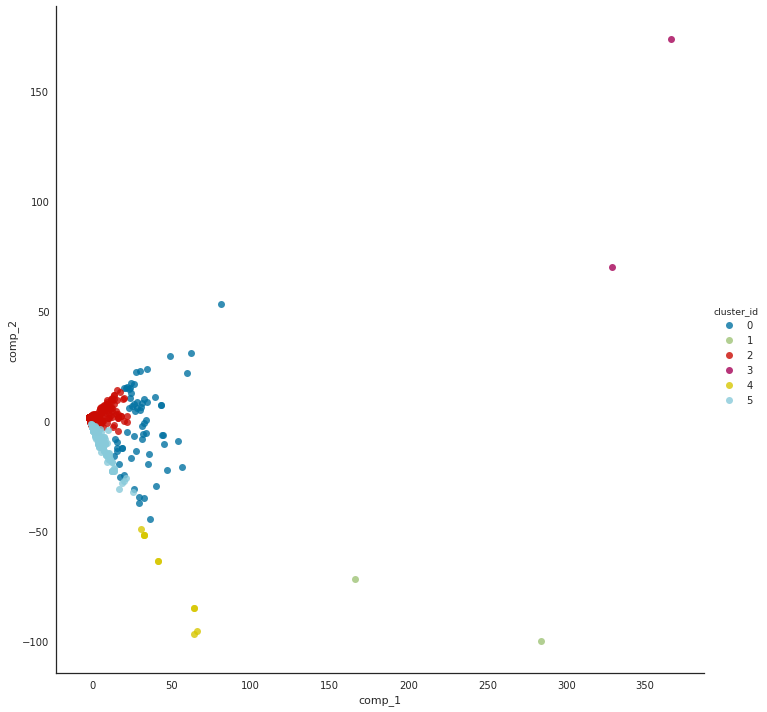

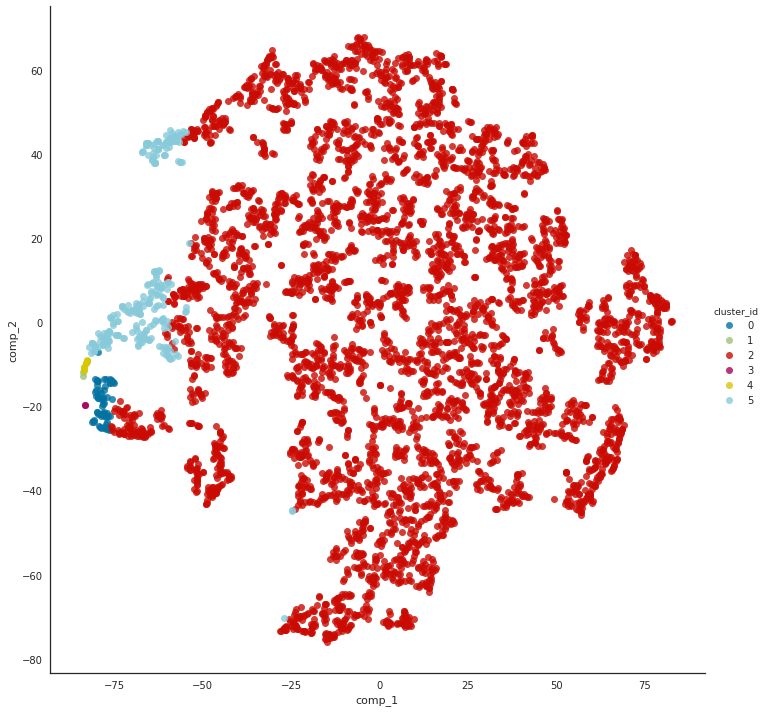

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)


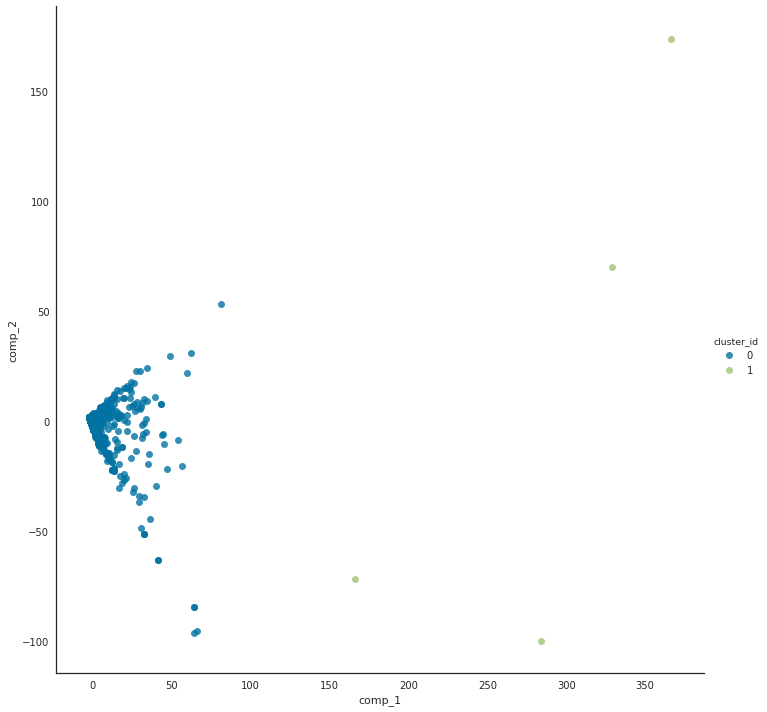

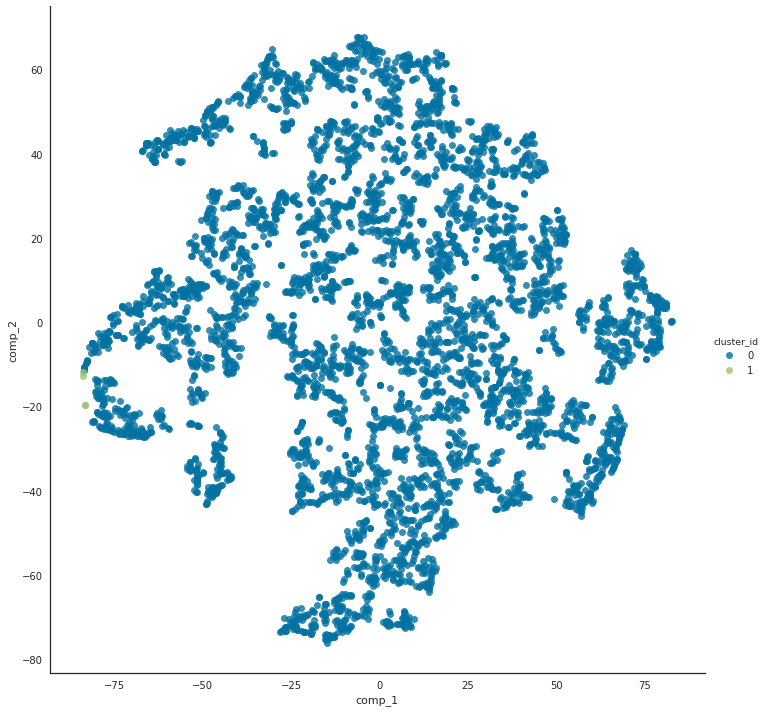

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)


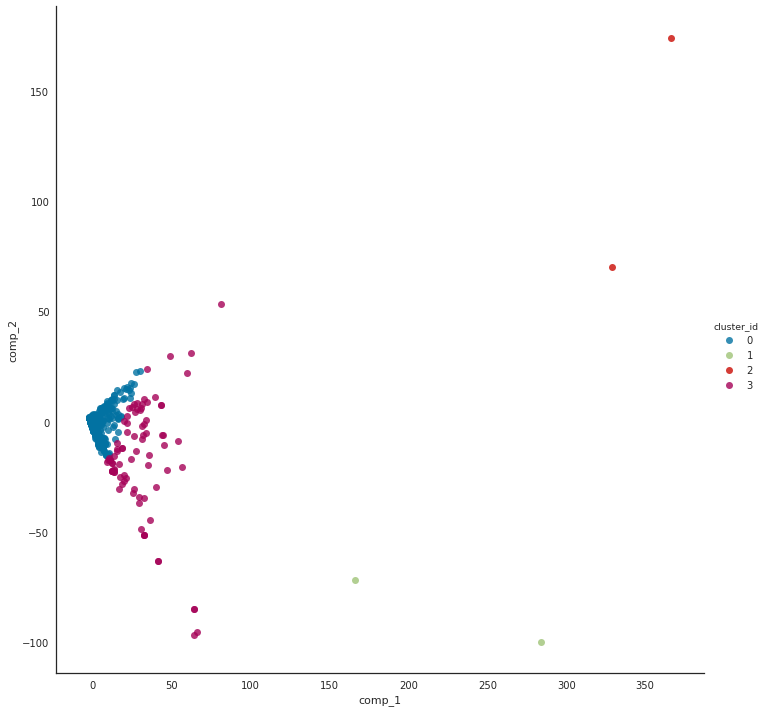

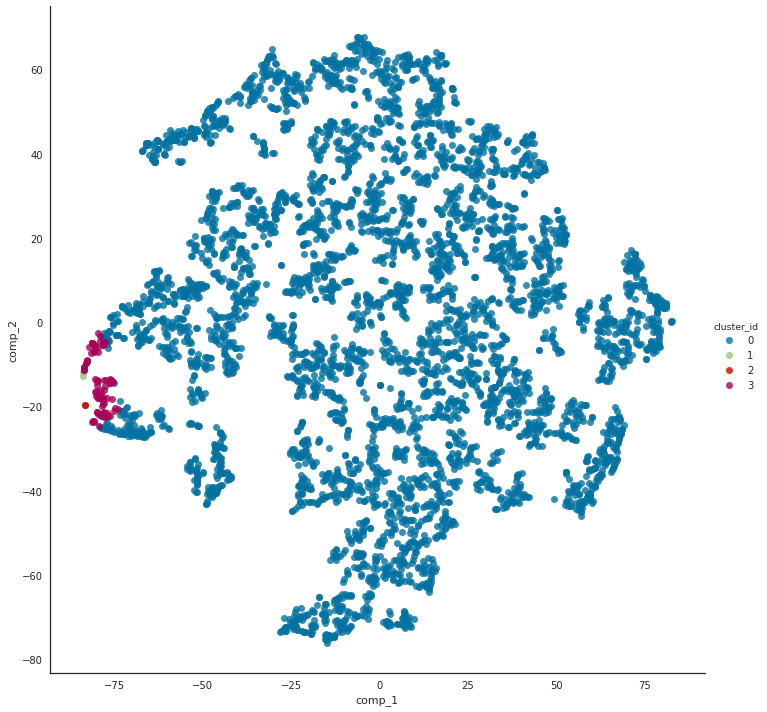

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)


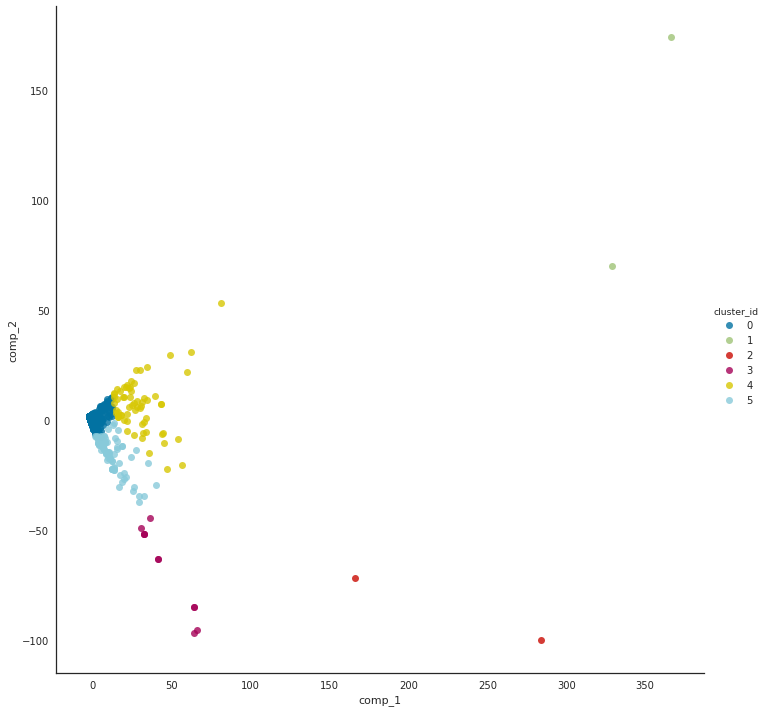

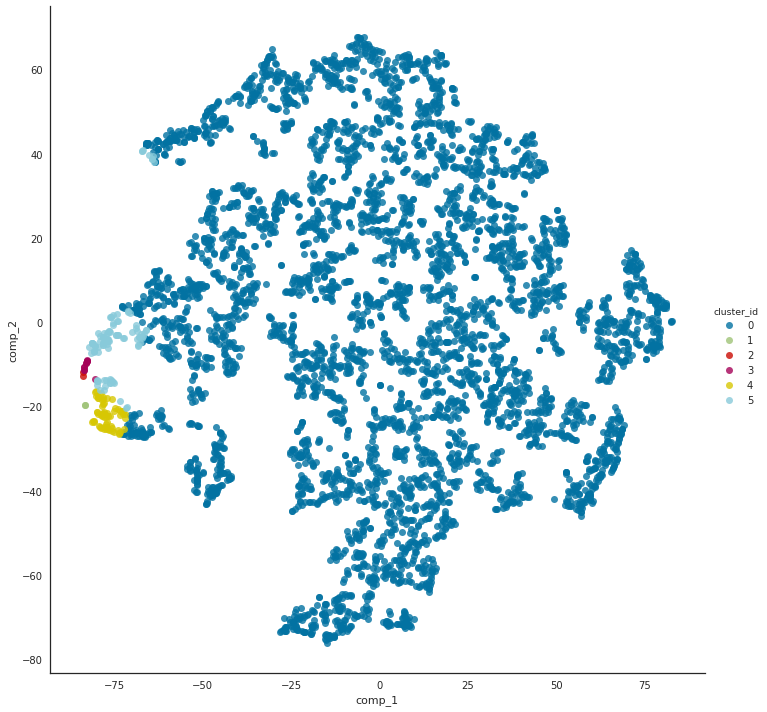

In [203]:
# Применим 2 других алгоритма кластеризации (AgglomerativeClustering и KMeans)
# с различным кол-во кластеров, получим основные хар-ки кластеров и визуализируем
# на данных после понижения размерности (PCA и TSNE)
cluster_grid = [{'clustering': [AgglomerativeClustering()],
                 'clustering__n_clusters': [2, 4, 6]},
                {'clustering': [KMeans()],
                 'clustering__n_clusters': [2, 4, 6],
                 'clustering__random_state': [random_state]}]
cluster_param_grid = ParameterGrid(cluster_grid)

for cluster_params in cluster_param_grid:
    cluster_pipeline.set_params(**cluster_params)
    cluster_labels = cluster_pipeline.fit_predict(processed_data)
    cluster_model = cluster_pipeline.named_steps['clustering']
    print(cluster_model)
    
    cluster_df[cluster_label] = cluster_labels
    cluster_members_df = cluster_df.groupby(cluster_label).head(2).sort_values(cluster_label)
    display(HTML(cluster_members_df.to_html()))
    
    cluster_info_df = cluster_df.groupby(cluster_label)[columns].mean()
    cluster_info_df['count'] = cluster_df[cluster_label].value_counts().sort_index()
    display(HTML(cluster_info_df.to_html()))
    
    pca_data[cluster_label] = cluster_labels
    pca_components_df = pd.DataFrame(pca_model.components_, columns=columns, index=pca_columns)
    sns.lmplot('comp_1', 'comp_2', data=pca_data, hue=cluster_label, fit_reg=False, size=10)
    plt.show()
    
    tsne_data[cluster_label] = cluster_labels
    sns.lmplot('comp_1', 'comp_2', data=tsne_data, hue=cluster_label, fit_reg=False, size=10)
    plt.show()

In [204]:
# Средние значения используемых признаков в оригинальном датасете
df[columns].mean()

price                 242.73
discount              519.41
ordered_item_count     12.15
order_price          2797.27
quantity                1.65
dtype: float64

**Выводы**  
В зависимости от кол-ва кластеров, для алгоритмов кластеризации можно выделить один крупный кластер, со средними значениями признаков, приблизительно совпадающих со средними значениями оригинальных признаков.  
Некоторые из остальных кластеров позволяют найти позиции чеков, в которых один из признаков существенно отличается от глобального среднего.

# Сегментация по клиентам

## Выбор и преобразование признаков

Признаки, используемые для сегментации клиентов RFM (https://medium.com/@jackiekhuu.work/customer-segmentation-rfm-analysis-8007d62101cc):
- recency (кол-во дней с момента последней покупки клиента)
    - Нормализовать
- frequency (общее число покупок клиента)
    - Нормализовать
- monetary (общая сумма покупок клиента)
    - Нормализовать
- rscore, fscore, mscore ???

In [205]:
# Создание признаков 
rfm_columns = ['recency', 'frequency', 'monetary']
rfm_df = (df.drop_duplicates('orderid')
            .groupby('user_id')
            .agg({'date_insert': 'max', 'orderid': 'count', 'order_price': 'sum'}))
rfm_df.columns = rfm_columns
rfm_df['recency'] = (pd.Timestamp.today() - rfm_df.recency).dt.days
rfm_df.head()

recency  frequency  monetary
user_id                              
3            248          4   6438.00
5            279         32  38285.67
10           238          3   2867.00
11           270         17  13477.00
22           241          1    886.00

In [206]:
# Преобразование выбранных признаков
proc_params = {'preprocessing__extract__columns': rfm_columns}
proc_pipeline.set_params(**proc_params)
proc_pipeline

Pipeline(memory=None,
     steps=[('sample', RandomSampler(random_state=42, samples_num=5000)), ('preprocessing', Pipeline(memory=None,
     steps=[('extract', ColumnExtractor(columns=['recency', 'frequency', 'monetary'])), ('normalize', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True))]))])

In [207]:
rfm_processed_data = proc_pipeline.fit_transform(rfm_df)

## Кластеризация и понижение размерности

In [208]:
# Кластеризация (DBSCAN) 
cluster_params = {'clustering': DBSCAN(),
                  'clustering__min_samples': k}
cluster_pipeline.set_params(**cluster_params)

cluster_labels = cluster_pipeline.fit_predict(rfm_processed_data)
cluster_model = cluster_pipeline.named_steps['clustering']
print(cluster_model)

DBSCAN(algorithm='auto', eps=0.5, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=4, n_jobs=1, p=None)


[40.121961971948103,
 26.210727948262612,
 16.00081589860325,
 13.555338145348038,
 12.211384631638074,
 11.03142865749229,
 10.204246045726586,
 7.8725219491341543,
 7.6801054198987355,
 7.4839499311357676]

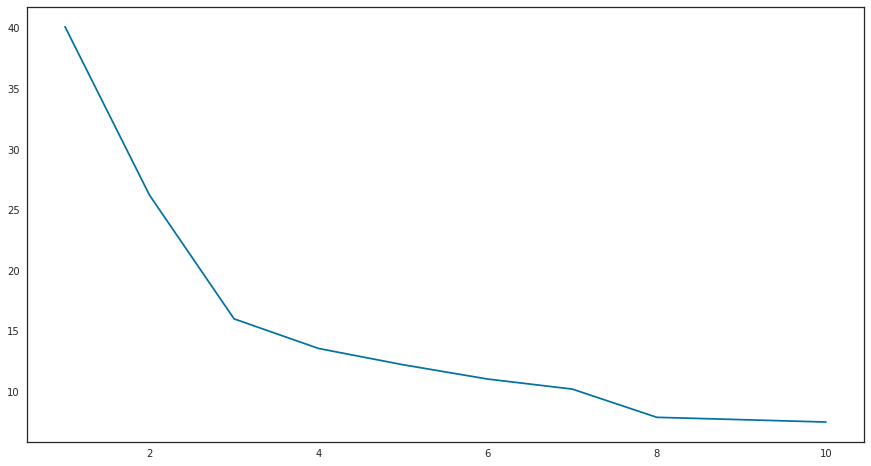

In [209]:
# Определение eps и min_pts для DBSCAN с помощью эвристики
nn = NearestNeighbors(n_neighbors=k).fit(rfm_processed_data)
distances, indices = nn.kneighbors(rfm_processed_data)
k_sorted_distances = sorted(distances[:,k-1], reverse=True)
plt.plot(np.arange(10) + 1, k_sorted_distances[:10])
k_sorted_distances[:10]

In [210]:
# Кластеризация на основе найденных параметров (eps = 7.9, min_pts = 8)
cluster_pipeline.set_params(clustering__eps=7.9, clustering__min_samples=8)
cluster_labels = cluster_pipeline.fit_predict(rfm_processed_data)
cluster_model = cluster_pipeline.named_steps['clustering']
print(cluster_model)

DBSCAN(algorithm='auto', eps=7.9, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=8, n_jobs=1, p=None)


In [211]:
# Понижение размерности (PCA)
dim_red_params = {'dim_reduction': PCA(),
                  'dim_reduction__random_state': random_state}
dim_red_pipeline.set_params(**dim_red_params)

pca_data = dim_red_pipeline.fit_transform(rfm_processed_data)
pca_columns = ['comp_' + str(i+1) for i in range(pca_data.shape[1])]
pca_data = pd.DataFrame(pca_data, columns=pca_columns)
pca_data[cluster_label] = cluster_labels

pca_model = dim_red_pipeline.named_steps['dim_reduction']
print(pca_model)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=42,
  svd_solver='auto', tol=0.0, whiten=False)


recency  frequency  monetary
comp_1    -0.02       0.22      0.98
comp_2    -0.07       0.97     -0.22
comp_3     1.00       0.07      0.00

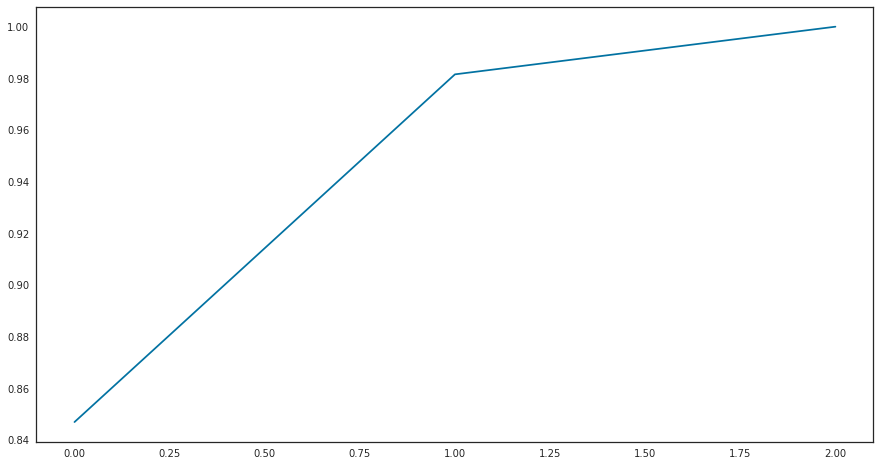

In [212]:
# Вывод графика объясненной дисперсии относительно первых n pca-компонент
plt.plot(pca_model.explained_variance_ratio_.cumsum())

# Определение коэффициентов для pca-компонент, на основе начальных признаков
pd.DataFrame(pca_model.components_, columns=rfm_columns, index=pca_columns)

In [213]:
# Понижение размерности (TSNE)
params = {'dim_reduction': TSNE(random_state=42)}
dim_red_pipeline.set_params(**params)

tsne_data = dim_red_pipeline.fit_transform(rfm_processed_data)
tsne_columns = ['comp_' + str(i+1) for i in range(tsne_data.shape[1])]
tsne_data = pd.DataFrame(tsne_data, columns=tsne_columns)
tsne_data[cluster_label] = cluster_labels

tsne_model = dim_red_pipeline.named_steps['dim_reduction']
print(tsne_model)

TSNE(angle=0.5, early_exaggeration=12.0, init='random', learning_rate=200.0,
   method='barnes_hut', metric='euclidean', min_grad_norm=1e-07,
   n_components=2, n_iter=1000, n_iter_without_progress=300,
   perplexity=30.0, random_state=42, verbose=0)


## Визуализация и описание кластеров

In [214]:
# Вывод позиций для каждого из полученных кластеров
cluster_df = rfm_df.sample(n=sample_size, random_state=random_state)
cluster_df[cluster_label] = cluster_labels
cluster_df.groupby(cluster_label).head(3).sort_values(cluster_label)

recency  frequency  monetary  cluster_id
user_id                                          
957017       250          7  70831.00          -1
111280       419          3 116393.00          -1
208238       325         30  43638.96          -1
933189       369          1   1519.55           0
969732       261          2   2268.00           0
889866       393          1    609.00           0

In [215]:
# Средние значения оригинальных признаков в разрезе кластеров
cluster_df.groupby(cluster_label)[rfm_columns].mean()

recency  frequency  monetary
cluster_id                              
-1           289.00      10.60  80910.99
 0           310.36       1.59   2498.89

In [216]:
cluster_df['cluster_id'].value_counts().sort_index()

-1      15
 0    4985
Name: cluster_id, dtype: int64

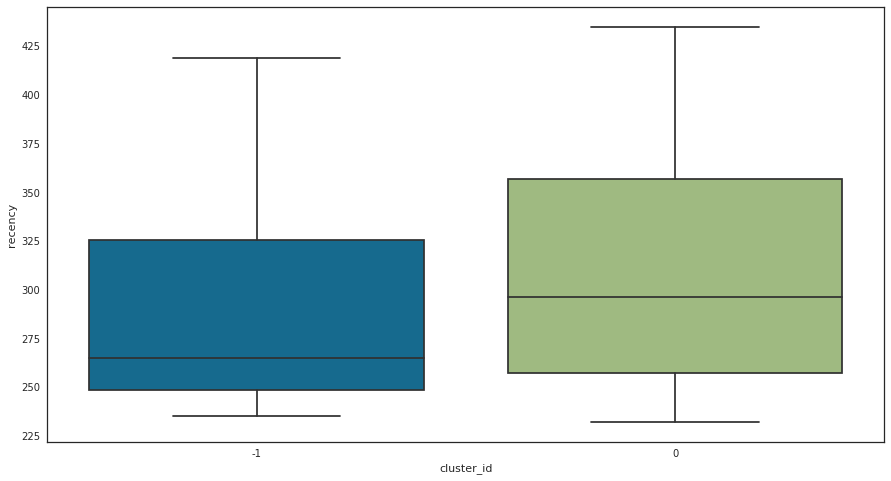

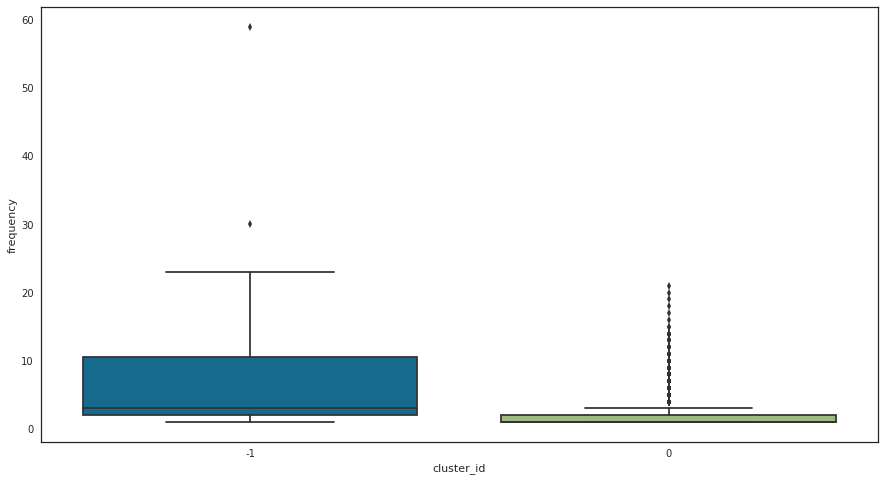

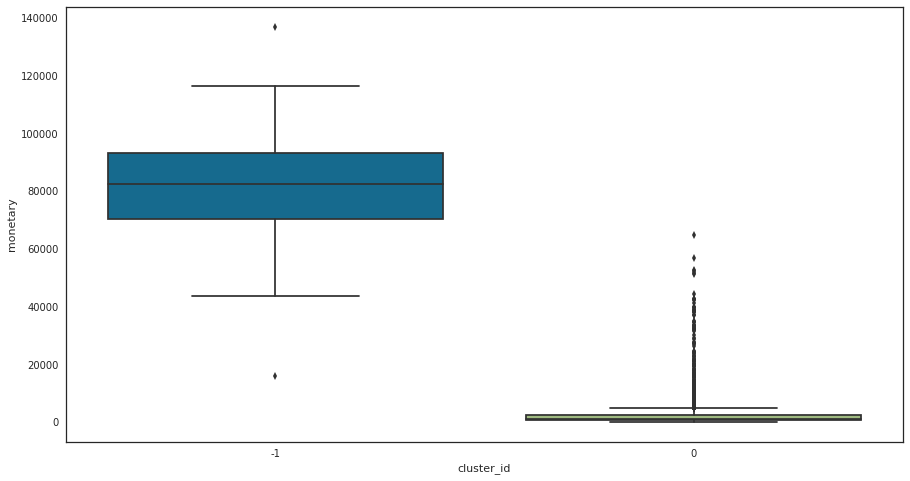

In [217]:
for col in rfm_columns:
    sns.boxplot('cluster_id', col, data=cluster_df)
    plt.show()

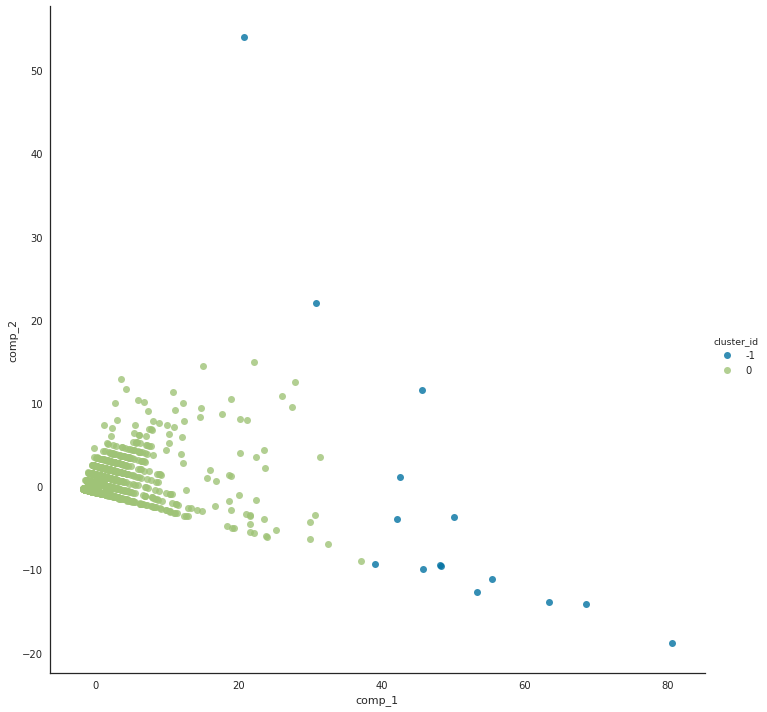

In [218]:
# Визуализация первых 2х pca-компонент
sns.lmplot('comp_1', 'comp_2', data=pca_data, hue=cluster_label, fit_reg=False, size=10)

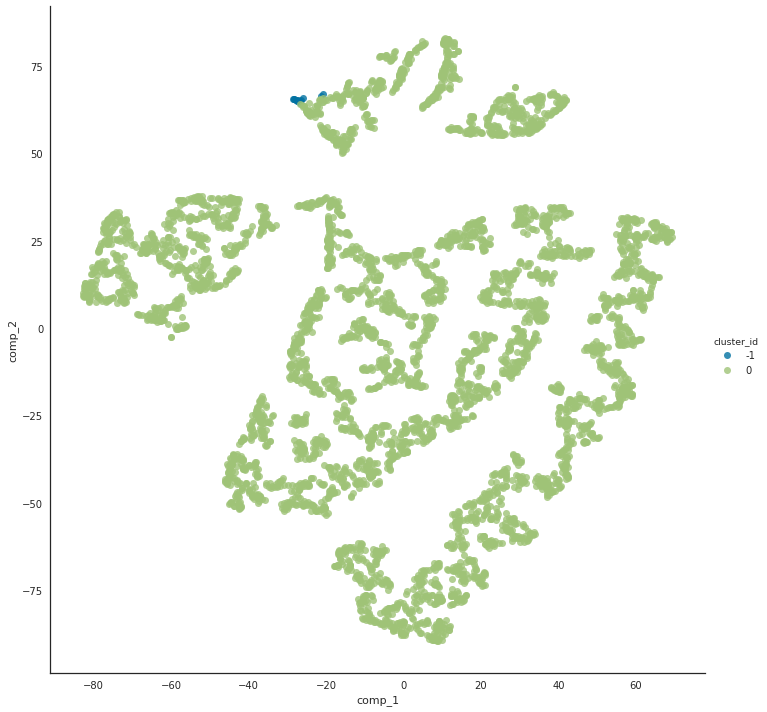

In [219]:
# Отобразим результаты кластеризации
sns.lmplot('comp_1', 'comp_2', data=tsne_data, hue=cluster_label, fit_reg=False, size=10)

**Выводы**  
Как можно увидеть, в кластере -1 ("шум" в терминологии DBSCAN) попали только несколько пользователей, у которых среднее значение частота покупок (frequency) и общая стоимость их покупок (monetary) в среднем существенно больше, чем в кластере 0. По дате последних покупок (recency) данные кластеры отличаются незначительно.  
Таким образом, мы выделили несколько клиентов с наибольшим кол-вом и частотой покупок среди всех остальных пользователей

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=2,
            pooling_func='deprecated')


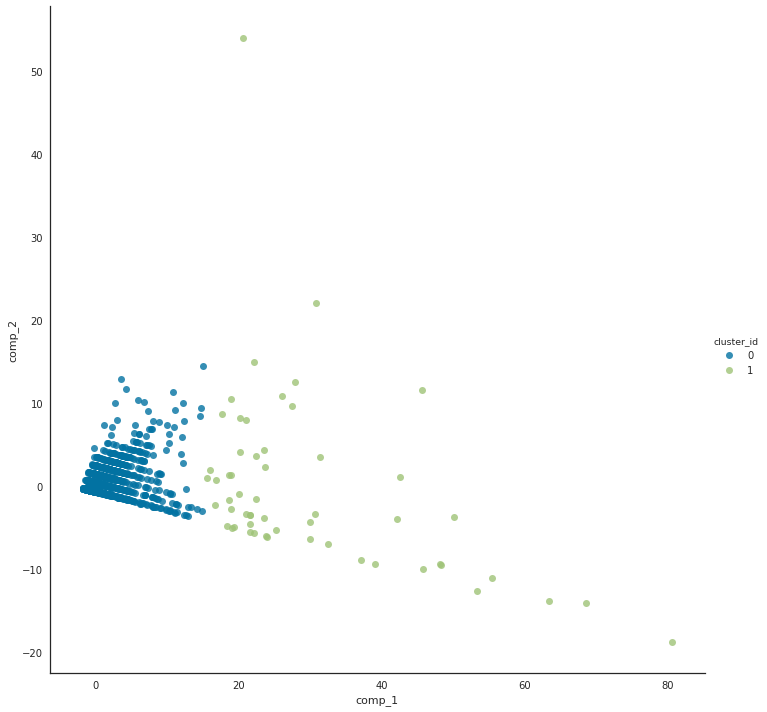

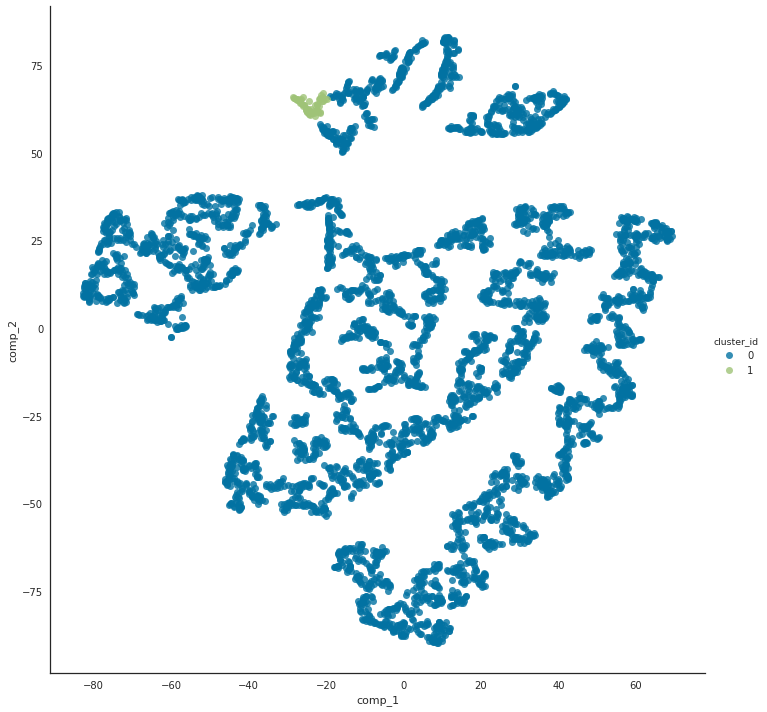

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=4,
            pooling_func='deprecated')


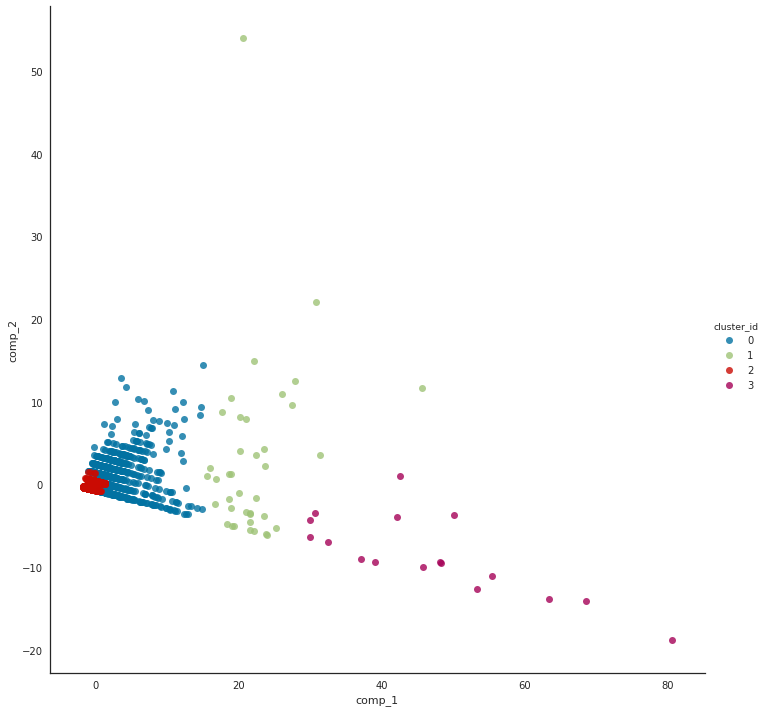

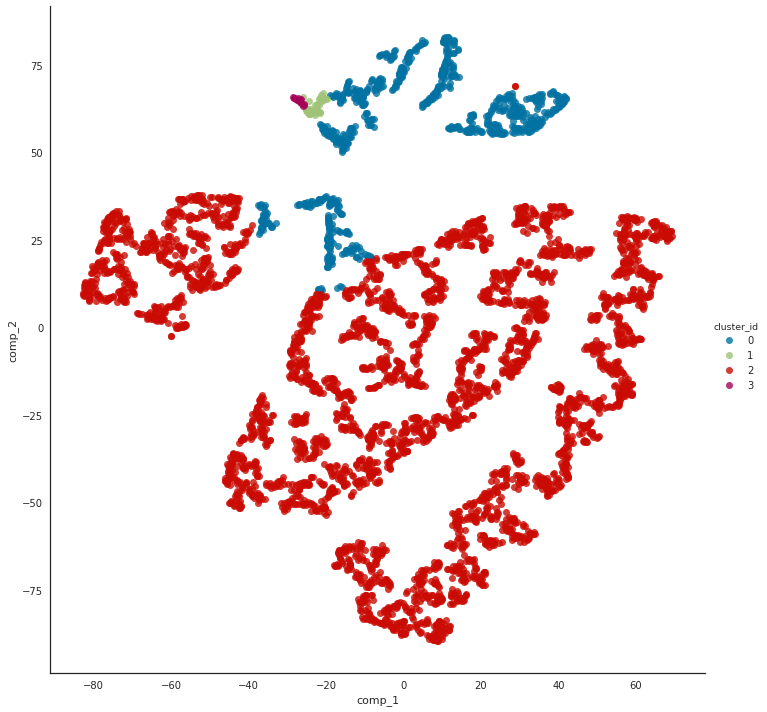

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=6,
            pooling_func='deprecated')


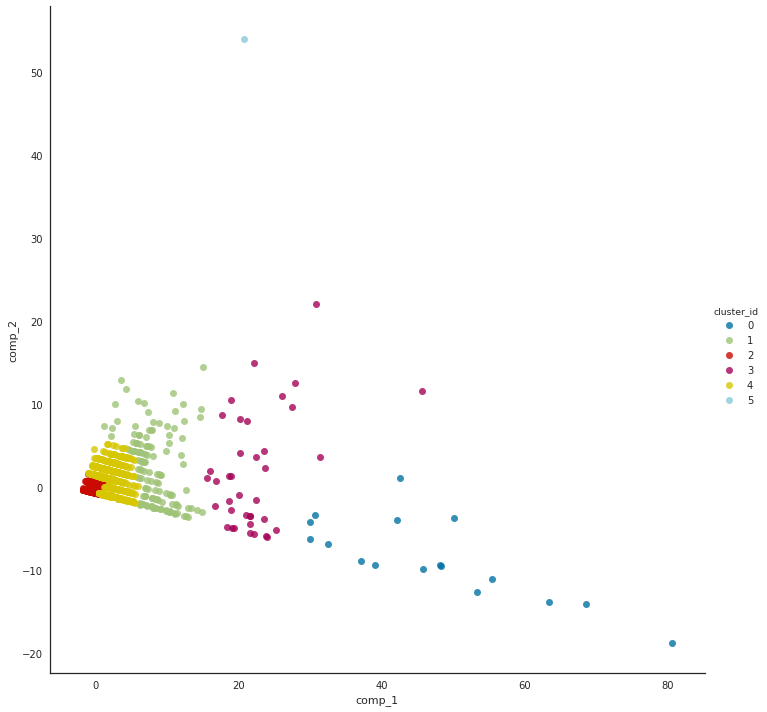

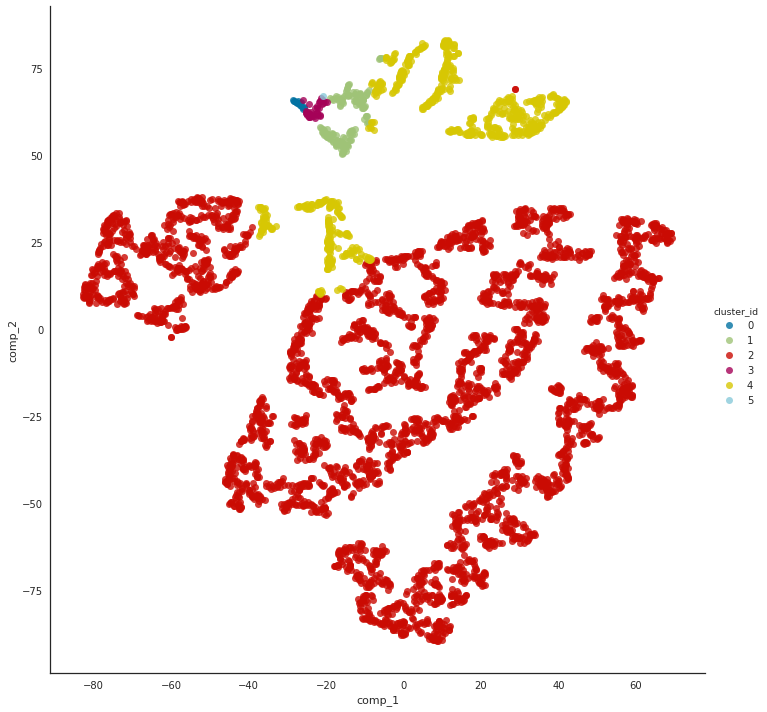

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)


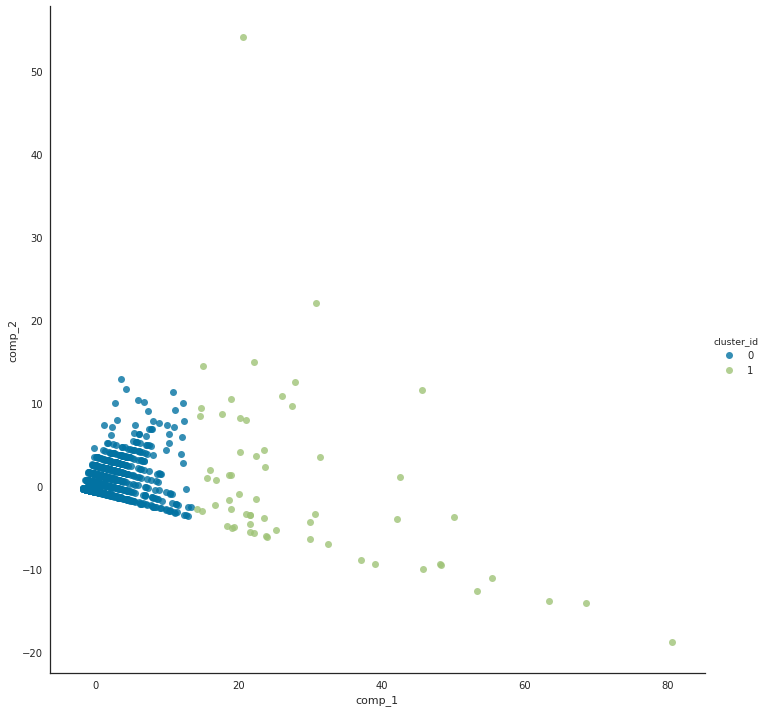

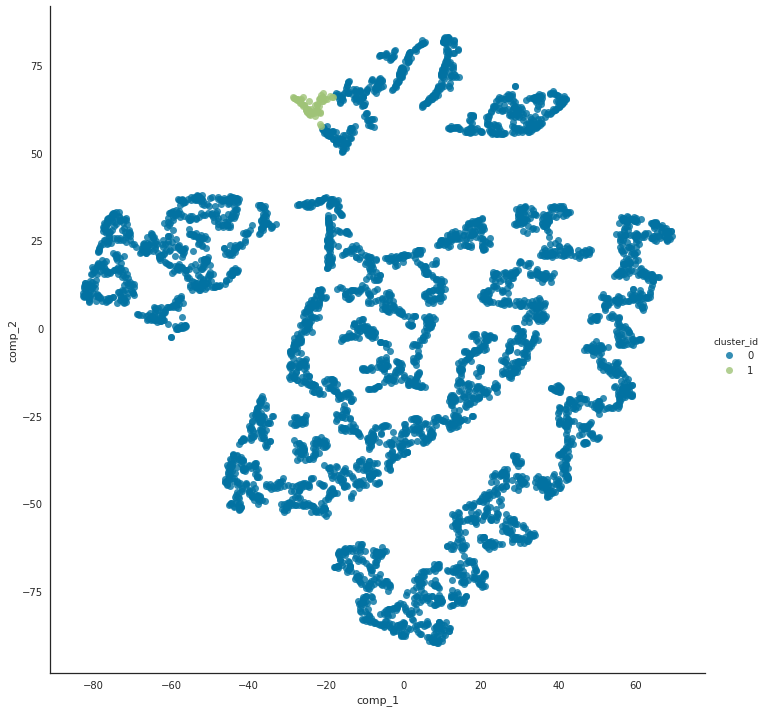

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)


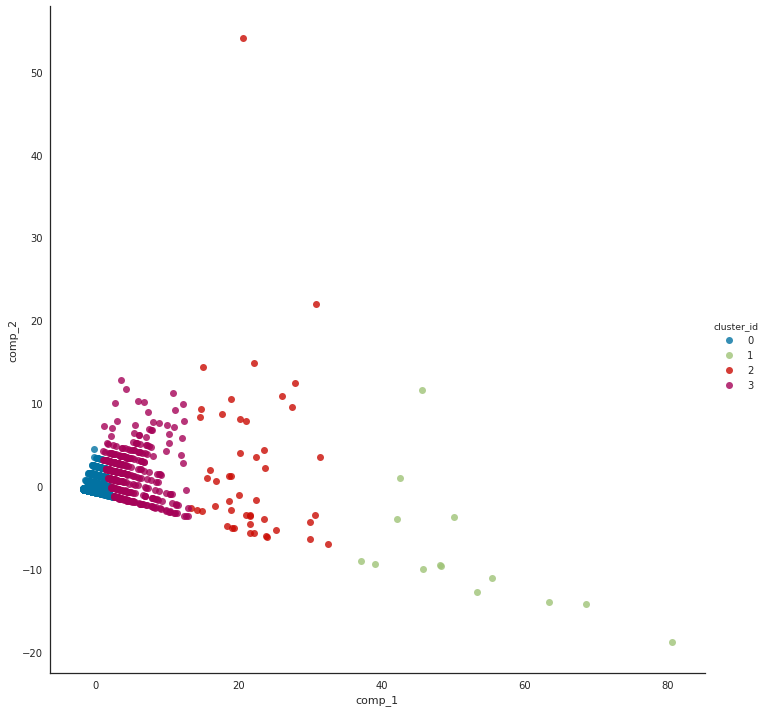

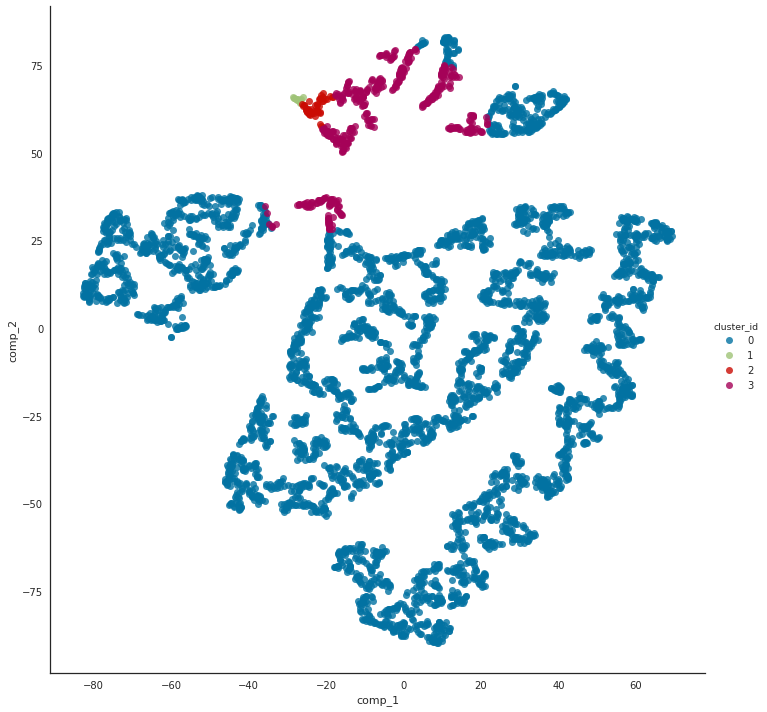

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)


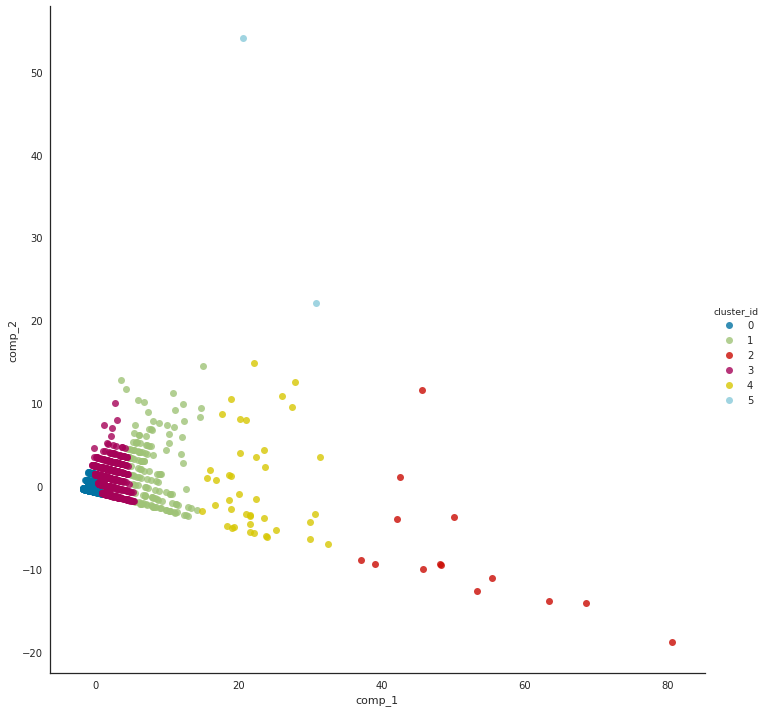

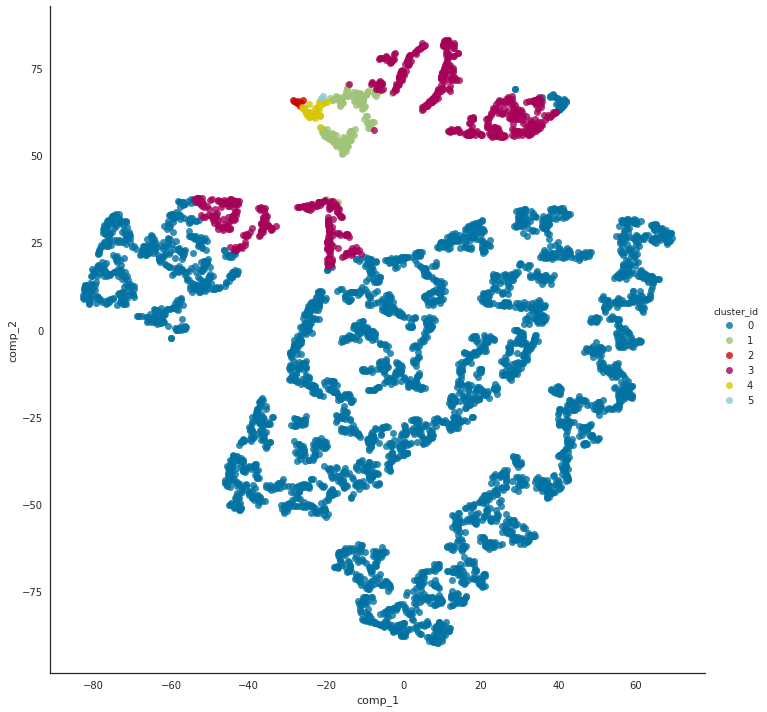

In [220]:
# Применим 2 других алгоритма кластеризации (AgglomerativeClustering и KMeans)
# с различным кол-во кластеров, получим основные хар-ки кластеров и визуализируем
# на данных после понижения размерности (PCA и TSNE)
cluster_grid = [{'clustering': [AgglomerativeClustering()],
                 'clustering__n_clusters': [2, 4, 6]},
                {'clustering': [KMeans()],
                 'clustering__n_clusters': [2, 4, 6],
                 'clustering__random_state': [random_state]}]
cluster_param_grid = ParameterGrid(cluster_grid)

for cluster_params in cluster_param_grid:
    cluster_pipeline.set_params(**cluster_params)
    cluster_labels = cluster_pipeline.fit_predict(rfm_processed_data)
    cluster_model = cluster_pipeline.named_steps['clustering']
    print(cluster_model)
    
    cluster_df[cluster_label] = cluster_labels
    cluster_members_df = cluster_df.groupby(cluster_label).head(2).sort_values(cluster_label)
    display(HTML(cluster_members_df.to_html()))
    
    cluster_info_df = cluster_df.groupby(cluster_label)[rfm_columns].mean()
    cluster_info_df['count'] = cluster_df[cluster_label].value_counts().sort_index()
    display(HTML(cluster_info_df.to_html()))
    
#     if type(cluster_model).__name__ == 'KMeans':
#         visualizer = SilhouetteVisualizer(cluster_model)
#         visualizer.fit(rfm_processed_data) 
#         visualizer.poof()
        
    pca_components_df = pd.DataFrame(pca_model.components_, columns=rfm_columns, index=pca_columns)
    display(HTML(pca_components_df.to_html()))
    
    pca_data[cluster_label] = cluster_labels
    sns.lmplot('comp_1', 'comp_2', data=pca_data, hue=cluster_label, fit_reg=False, size=10)
    plt.show()
    
    tsne_data[cluster_label] = cluster_labels
    sns.lmplot('comp_1', 'comp_2', data=tsne_data, hue=cluster_label, fit_reg=False, size=10)
    plt.show()

In [221]:
rfm_df.mean()

recency      309.57
frequency      1.67
monetary    2790.73
dtype: float64

**Вывод**  
Исходя из результатов, можно сделать предположение, что на основе данных признаков и выбранного кол-ва кластеров (n), можно выделить n различных категорий пользователей относительно частоты их покупок (frequency) и/или общей суммы покупок (monetary), и кол-во дней от последней покупки (recency) не вносит значительной дополнительной информации для кластеризации.

# Сегментация по продуктам

## Выбор и преобразование признаков

Признаки, используемые для сегментации клиентов RFM (https://medium.com/@jackiekhuu.work/customer-segmentation-rfm-analysis-8007d62101cc):
- mean_price (средняя цена продукта)
    - Нормализовать
- total_price (общее число покупок клиента)
    - Нормализовать
- mean_discount (средняя сумма скидки чек, где присутствует данный продукт)
    - Нормализовать
- order_count (общее кол-во чеков, где присутствует данный продукт)
    - Нормализовать
- mean_quantity (среднее кол-во продукта в чеках, где он присутствует)
    - Нормализовать
- mean_ordered_item_count (среднее кол-во позиций в чеках, где присутствует товар)
    - Нормализовать

In [222]:
df.head()

discount_value                                               name  price  \
0            0.24                              Хроники Амбера. Том 2 357.00   
1            0.04                              Хроники Амбера. Том 1 448.00   
2            0.04                                       Пищеводитель 414.00   
3            0.04  Аудиокн. Мясников. &quot;Ржавчина&quot;: что д... 253.00   
4            0.04       Инфекции. Как защитить себя и своего ребенка 422.00   

   quantity         date_insert  discount   itemid  orderid  \
0         1 2017-03-19 22:25:20    110.00   169108   602051   
1         1 2017-03-19 22:19:58     19.00  1394744   602047   
2         1 2017-03-19 20:58:00     65.00   191276   602017   
3         1 2017-03-19 20:58:00     65.00   157945   602017   
4         1 2017-03-19 20:58:00     65.00   205173   602017   

   ordered_item_count  order_price  user_id  
0                   1       527.00   911531  
1                   1       618.00   911531  
2                   4      1503.00   911587  
3                   4      1503.00   911587  
4                   4      1503.00   911587

In [223]:
prod_columns = ['mean_price', 'total_price', 'mean_discount', 'order_count', 
                   'mean_quantitiy', 'mean_ordered_item_count']
prod_df = (df.groupby('itemid')
             .agg({'price': ['mean', 'sum'], 'discount': 'mean', 'quantity': 'mean',
                   'orderid': 'count', 'ordered_item_count': 'mean'}))
prod_df.columns = prod_columns
prod_df.head()

mean_price  total_price  mean_discount  order_count  mean_quantitiy  \
itemid                                                                        
131823       41.40       207.00        1150.40         1.40               5   
131876     1159.00      1159.00         290.00         1.00               1   
131884       71.75       287.00         366.25         1.00               4   
132034       29.67        89.00         469.33         1.00               3   
132062      577.78      5200.00        1038.11         1.11               9   

        mean_ordered_item_count  
itemid                           
131823                    33.20  
131876                     1.00  
131884                    19.50  
132034                    27.00  
132062                     8.56

In [224]:
# Преобразование выбранных признаков
proc_params = {'preprocessing__extract__columns': prod_columns}
proc_pipeline.set_params(**proc_params)
proc_pipeline

Pipeline(memory=None,
     steps=[('sample', RandomSampler(random_state=42, samples_num=5000)), ('preprocessing', Pipeline(memory=None,
     steps=[('extract', ColumnExtractor(columns=['mean_price', 'total_price', 'mean_discount', 'order_count', 'mean_quantitiy', 'mean_ordered_item_count'])), ('normalize', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True))]))])

In [225]:
prod_processed_data = proc_pipeline.fit_transform(prod_df)

## Кластеризация и понижение размерности

In [226]:
# Кластеризация (DBSCAN) 
cluster_params = {'clustering': DBSCAN(),
                  'clustering__min_samples': k}
cluster_pipeline.set_params(**cluster_params)

cluster_labels = cluster_pipeline.fit_predict(prod_processed_data)
cluster_model = cluster_pipeline.named_steps['clustering']
print(cluster_model)

DBSCAN(algorithm='auto', eps=0.5, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=4, n_jobs=1, p=None)


[1063.6465091912835,
 331.30855939725876,
 161.98825694869618,
 122.06205589598521,
 104.6224347955341,
 99.837842218976732,
 87.187098315466883,
 77.820576171419049,
 77.290919020415529,
 73.547484354568496]

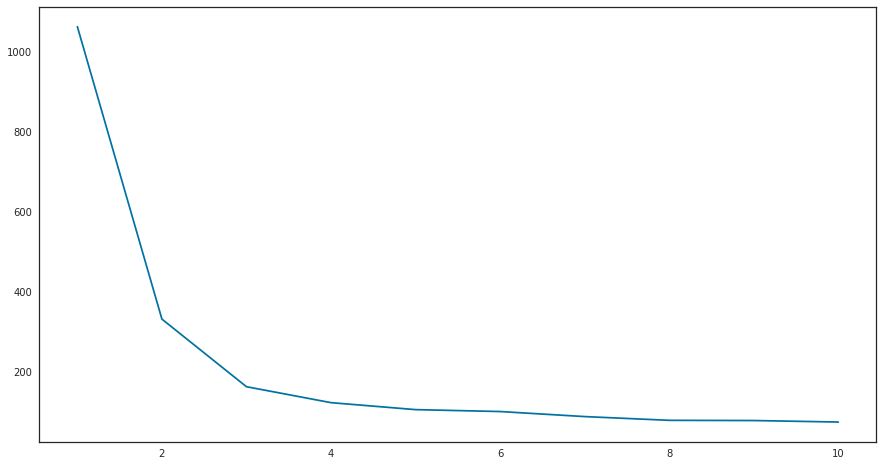

In [227]:
# Определение eps и min_pts для DBSCAN с помощью эвристики
nn = NearestNeighbors(n_neighbors=k).fit(prod_processed_data)
distances, indices = nn.kneighbors(prod_processed_data)
k_sorted_distances = sorted(distances[:,k-1], reverse=True)
plt.plot(np.arange(10) + 1, k_sorted_distances[:10])
k_sorted_distances[:10]

In [228]:
# Кластеризация на основе найденных параметров (eps = 77.8, min_pts = 8)
cluster_pipeline.set_params(clustering__eps=77.8, clustering__min_samples=8)
cluster_labels = cluster_pipeline.fit_predict(prod_processed_data)
cluster_model = cluster_pipeline.named_steps['clustering']
print(cluster_model)

DBSCAN(algorithm='auto', eps=77.8, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=8, n_jobs=1, p=None)


In [229]:
# Понижение размерности (PCA)
dim_red_params = {'dim_reduction': PCA(),
                  'dim_reduction__random_state': random_state}
dim_red_pipeline.set_params(**dim_red_params)

pca_data = dim_red_pipeline.fit_transform(prod_processed_data)
pca_columns = ['comp_' + str(i+1) for i in range(pca_data.shape[1])]
pca_data = pd.DataFrame(pca_data, columns=pca_columns)
pca_data[cluster_label] = cluster_labels

pca_model = dim_red_pipeline.named_steps['dim_reduction']
print(pca_model)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=42,
  svd_solver='auto', tol=0.0, whiten=False)


mean_price  total_price  mean_discount  order_count  mean_quantitiy  \
comp_1       -0.00         0.00          -0.00         1.00            0.00   
comp_2        0.08         0.90          -0.02        -0.00            0.42   
comp_3        0.02         0.03           0.91         0.00            0.00   
comp_4        0.95         0.03           0.05         0.00           -0.26   
comp_5        0.27        -0.42          -0.05        -0.00            0.86   
comp_6        0.13         0.09          -0.41         0.00           -0.15   

        mean_ordered_item_count  
comp_1                    -0.00  
comp_2                    -0.04  
comp_3                     0.41  
comp_4                    -0.17  
comp_5                     0.13  
comp_6                     0.89

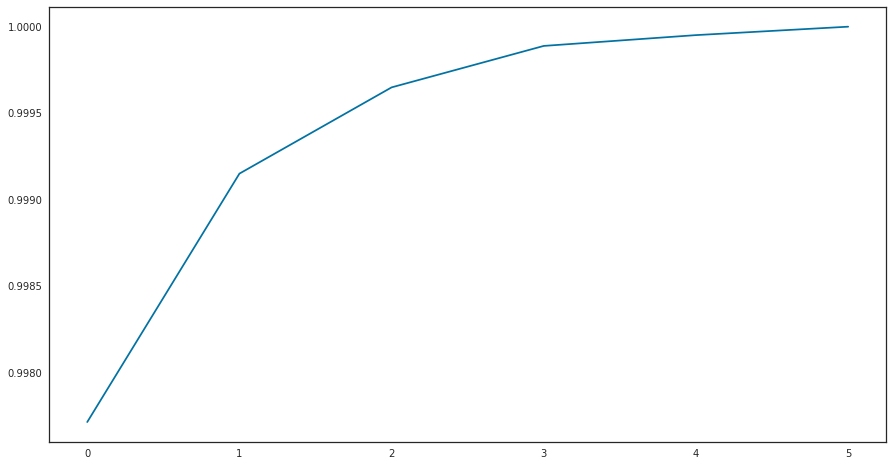

In [230]:
# Вывод графика объясненной дисперсии относительно первых n pca-компонент
plt.plot(pca_model.explained_variance_ratio_.cumsum())

# Определение коэффициентов для pca-компонент, на основе начальных признаков
pd.DataFrame(pca_model.components_, columns=prod_columns, index=pca_columns)

In [231]:
# Понижение размерности (TSNE)
params = {'dim_reduction': TSNE(random_state=42)}
dim_red_pipeline.set_params(**params)

tsne_data = dim_red_pipeline.fit_transform(rfm_processed_data)
tsne_columns = ['comp_' + str(i+1) for i in range(tsne_data.shape[1])]
tsne_data = pd.DataFrame(tsne_data, columns=tsne_columns)
tsne_data[cluster_label] = cluster_labels

tsne_model = dim_red_pipeline.named_steps['dim_reduction']
print(tsne_model)

TSNE(angle=0.5, early_exaggeration=12.0, init='random', learning_rate=200.0,
   method='barnes_hut', metric='euclidean', min_grad_norm=1e-07,
   n_components=2, n_iter=1000, n_iter_without_progress=300,
   perplexity=30.0, random_state=42, verbose=0)


## Визуализация и описание кластеров

In [232]:
# Вывод позиций для каждого из полученных кластеров
cluster_df = prod_df.sample(n=sample_size, random_state=random_state)
cluster_df[cluster_label] = cluster_labels
cluster_df.groupby(cluster_label).head(3).sort_values(cluster_label)

mean_price  total_price  mean_discount  order_count  mean_quantitiy  \
itemid                                                                         
1609212      424.50       849.00          57.50        25.00               2   
141817       126.00       504.00         288.50        25.75               4   
1704971      130.64       391.92          34.36        22.33               3   
180434       255.94      6910.50         493.71         1.04              27   
1631663      635.80      3179.00         396.40         1.00               5   
177509        44.57       312.00         345.71         1.00               7   

         mean_ordered_item_count  cluster_id  
itemid                                        
1609212                     1.00          -1  
141817                      6.00          -1  
1704971                     1.00          -1  
180434                      7.41           0  
1631663                     3.80           0  
177509                     26.86           0

In [233]:
# Средние значения оригинальных признаков в разрезе кластеров
cluster_df.groupby(cluster_label)[prod_columns].mean()

mean_price  total_price  mean_discount  order_count  \
cluster_id                                                        
-1              247.06     22085.79         274.70        22.94   
 0              231.73      2452.51         592.85         1.33   

            mean_quantitiy  mean_ordered_item_count  
cluster_id                                           
-1                   64.53                     4.81  
 0                   10.57                    14.33

In [234]:
cluster_df['cluster_id'].value_counts().sort_index()

-1      17
 0    4983
Name: cluster_id, dtype: int64

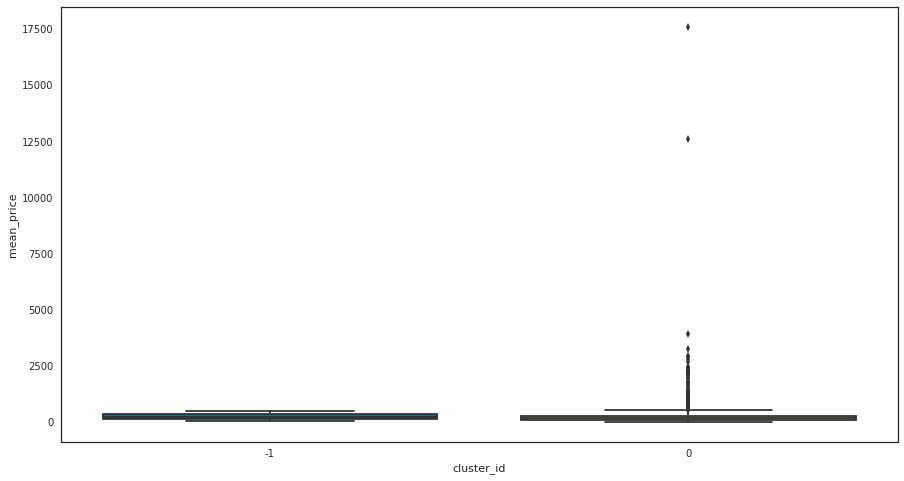

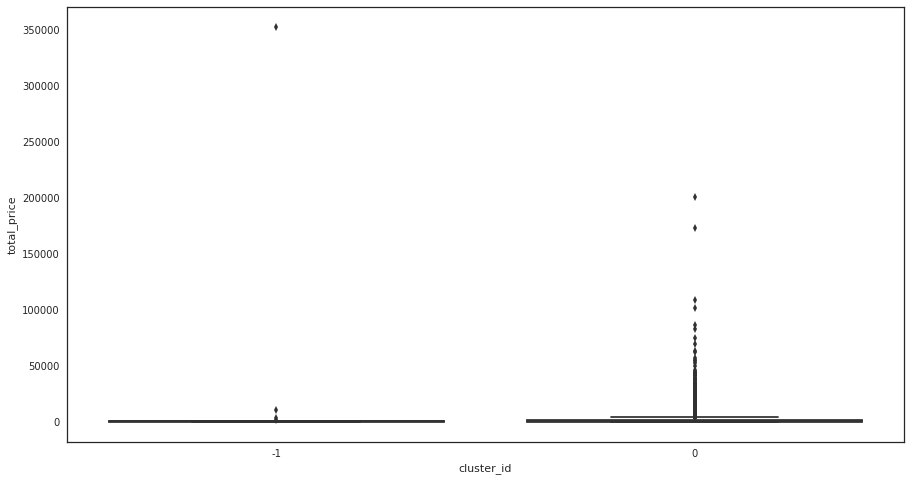

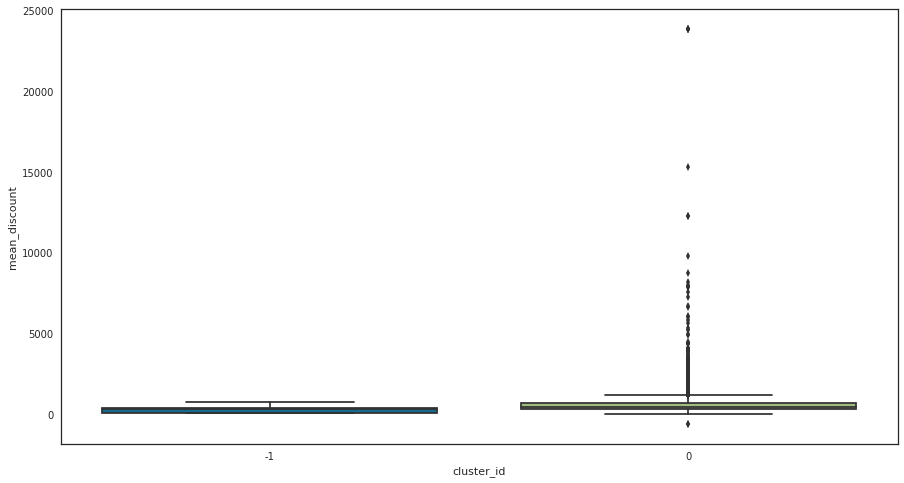

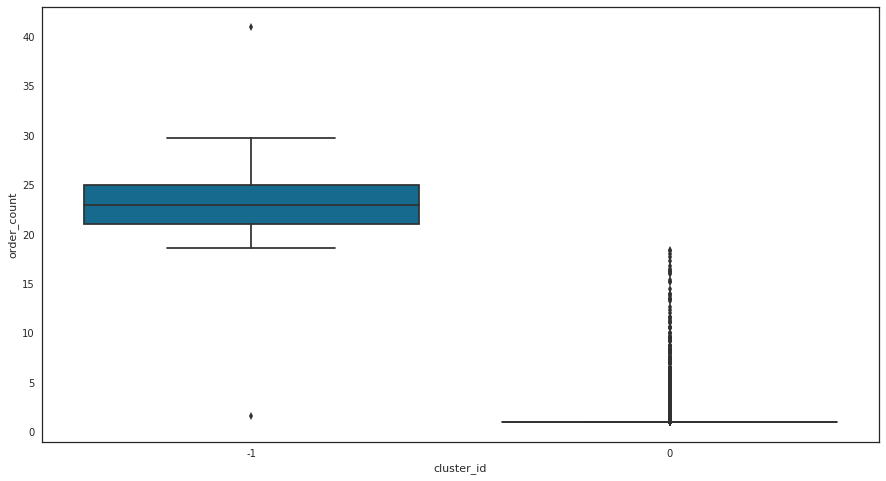

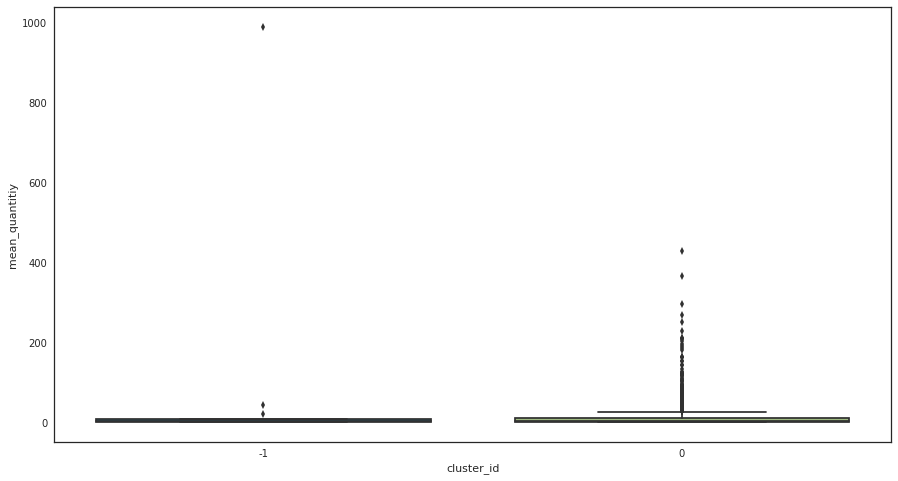

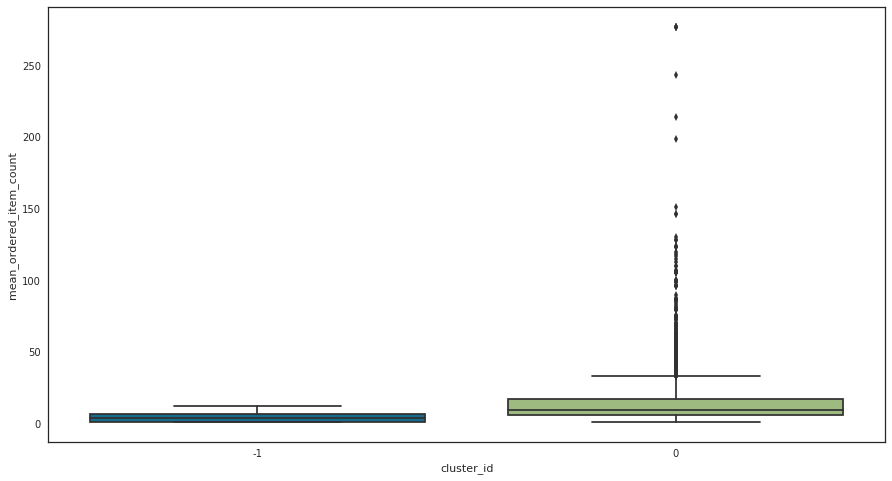

In [235]:
for col in prod_columns:
    sns.boxplot('cluster_id', col, data=cluster_df)
    plt.show()

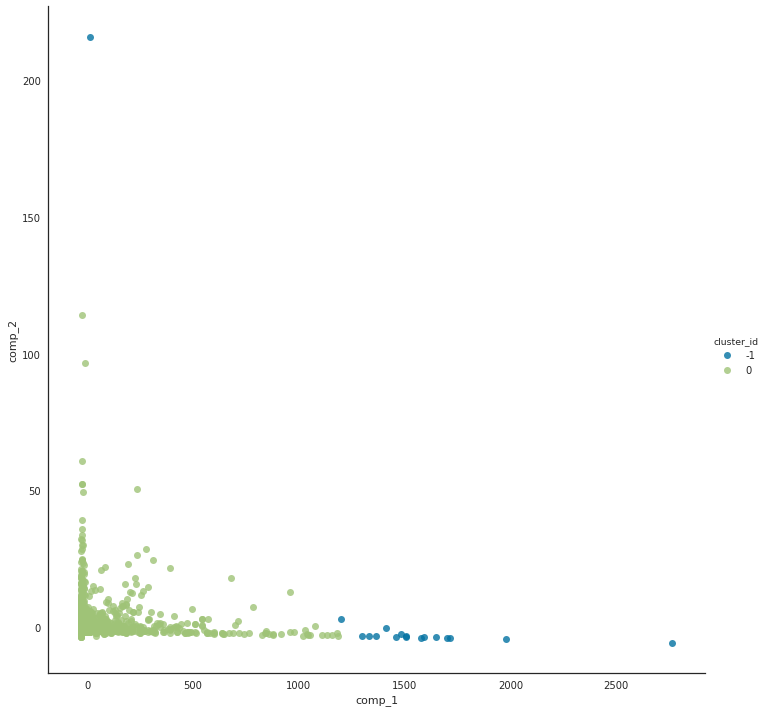

In [236]:
# Визуализация первых 2х pca-компонент
sns.lmplot('comp_1', 'comp_2', data=pca_data, hue=cluster_label, fit_reg=False, size=10)

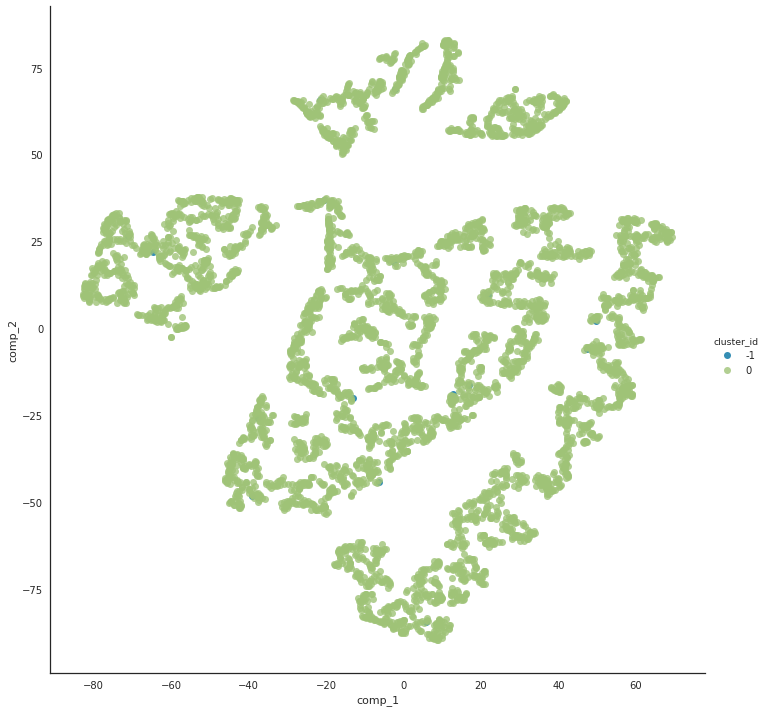

In [237]:
# Отобразим результаты кластеризации
sns.lmplot('comp_1', 'comp_2', data=tsne_data, hue=cluster_label, fit_reg=False, size=10)

**Выводы**  
Как можно увидеть, в кластере -1 ("шум" в терминологии DBSCAN) попали только несколько продуктов, у которых среднее кол-во чеков, в котором он присутствует (mean_order_count), значительно больше, чем в кластере 0, а кол-во позиций в чеке, где присутствует продукт, наборот, в среднем значительно меньше, чем в кластере 0.  
Таким образом, мы выделили несколько продуктов, которые часто покупают, и чаще всего при покупке данных продуктов в среднем редко покупают другие продукты.

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=2,
            pooling_func='deprecated')


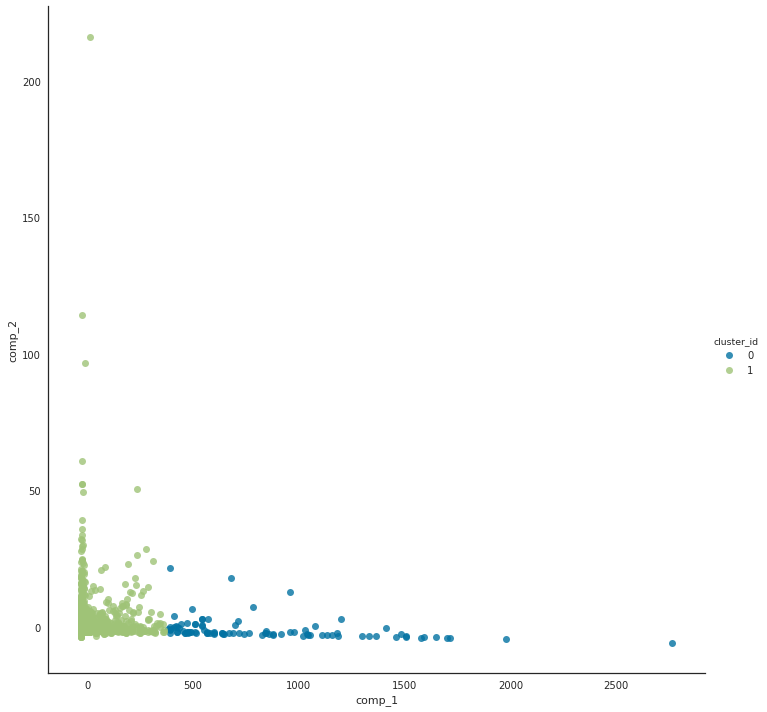

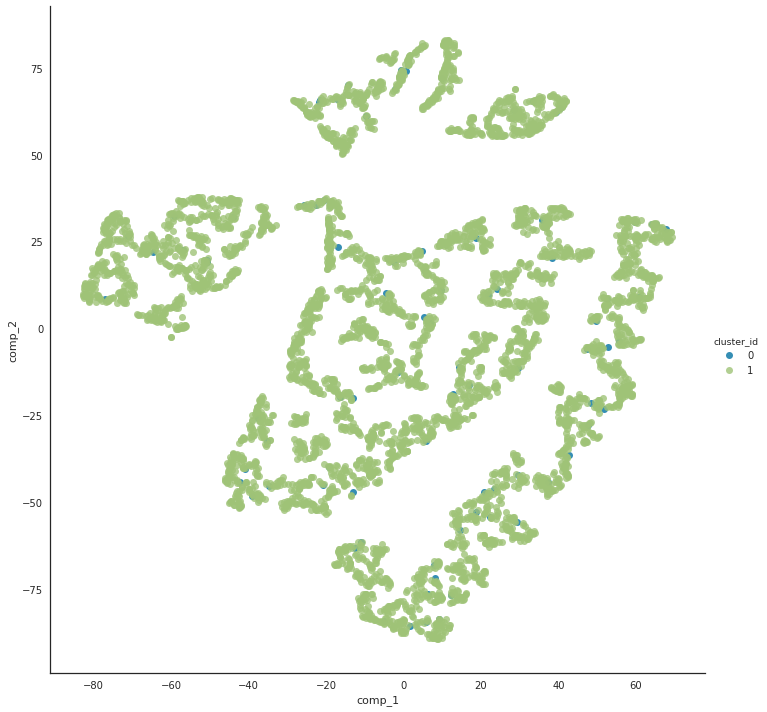

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=4,
            pooling_func='deprecated')


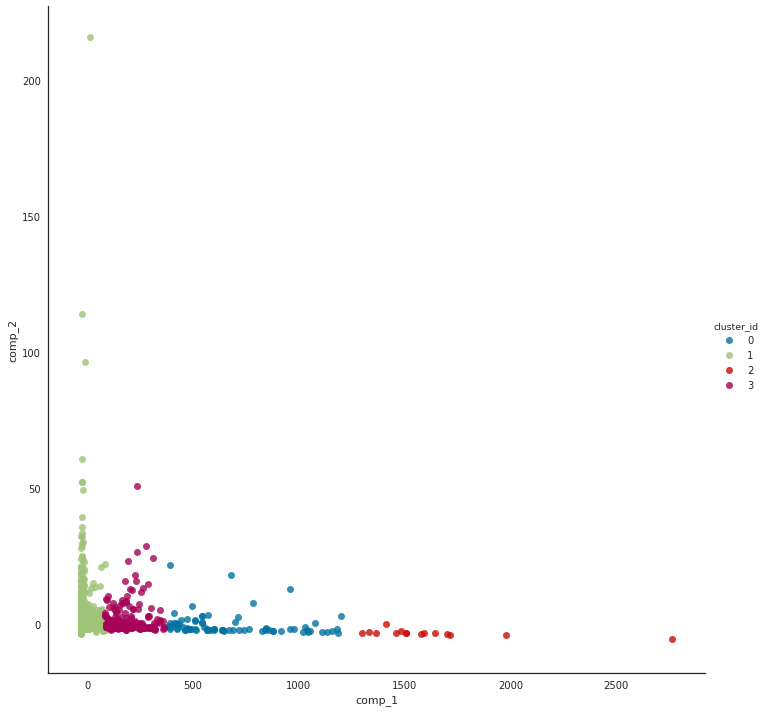

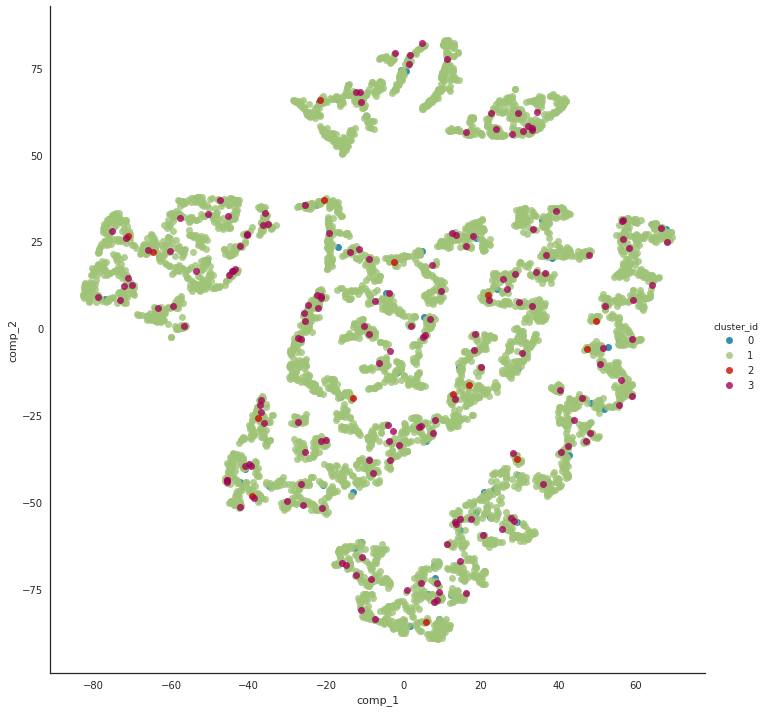

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=6,
            pooling_func='deprecated')


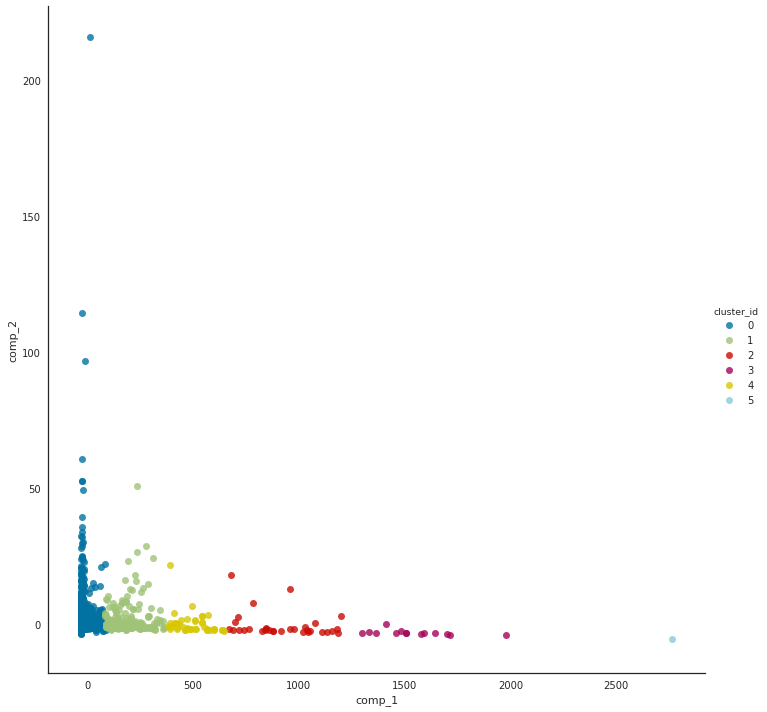

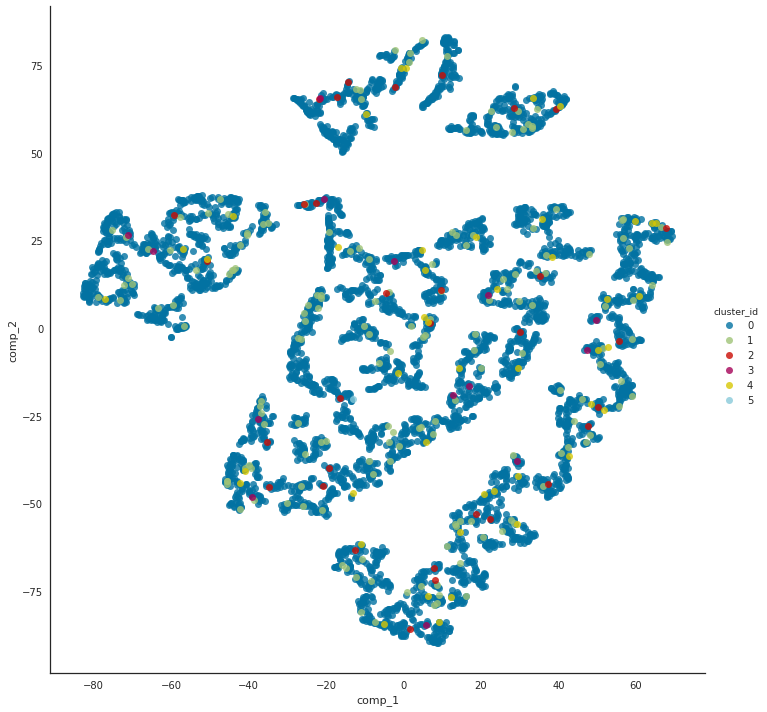

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)


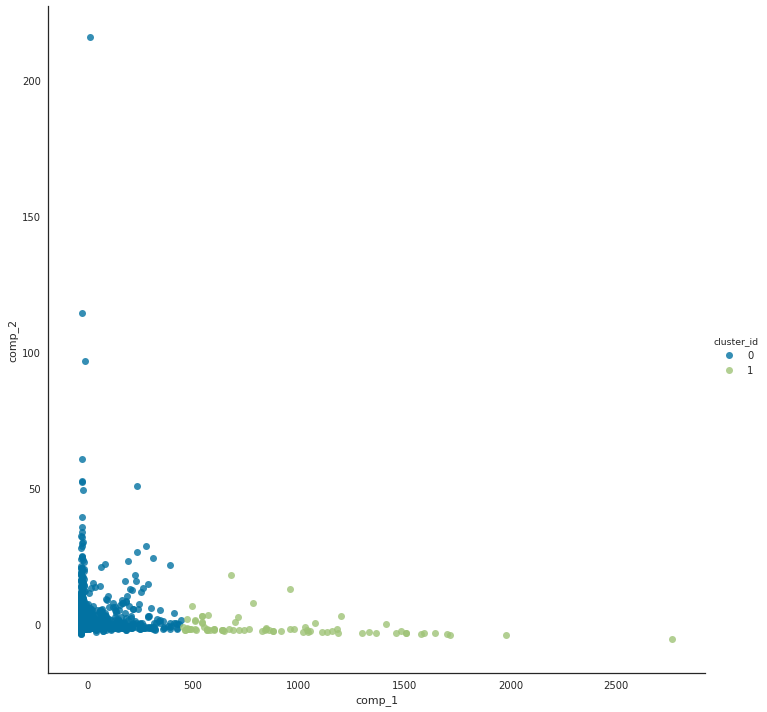

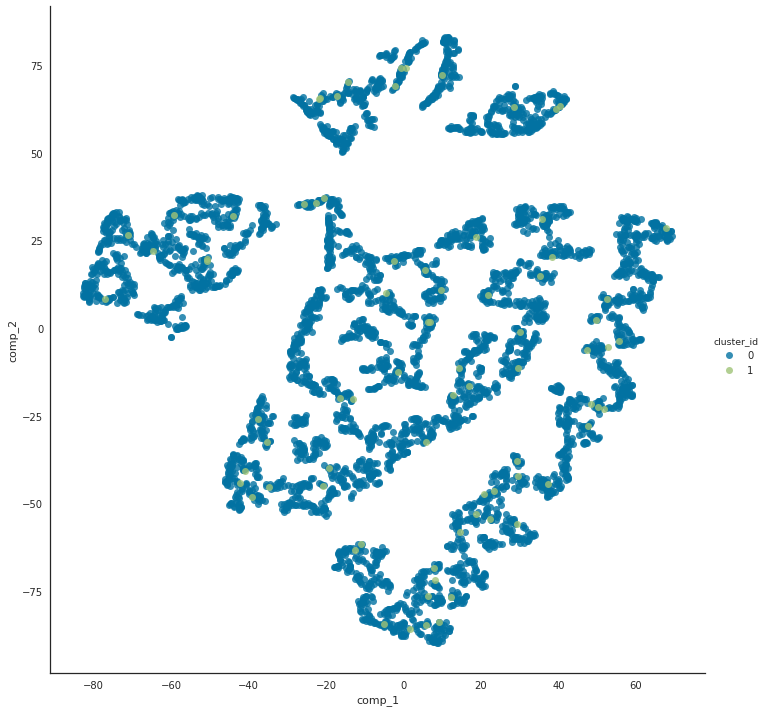

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)


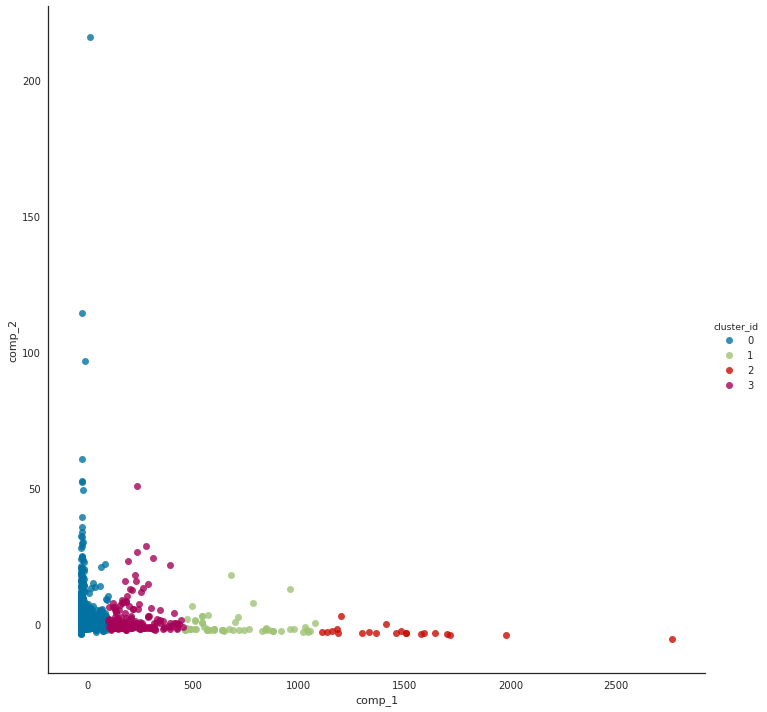

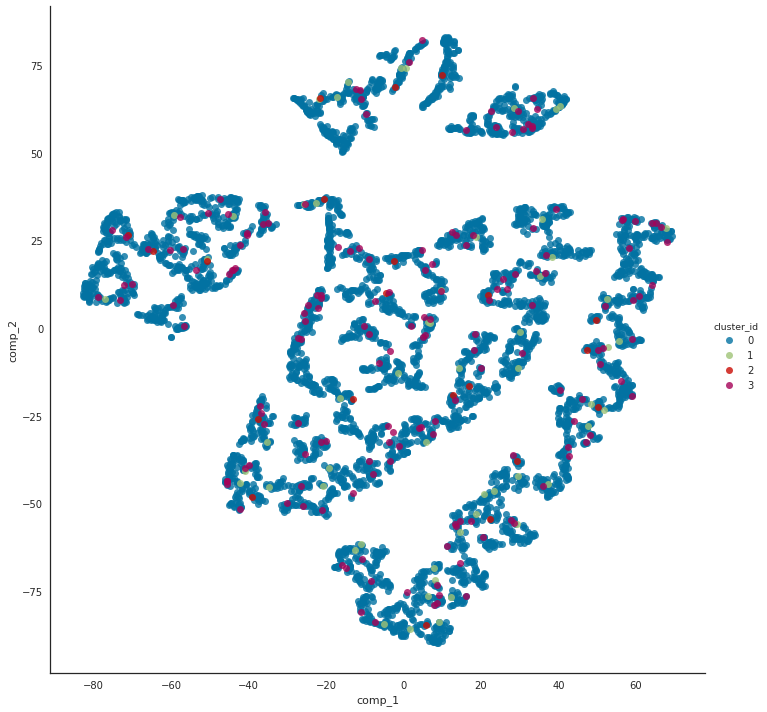

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)


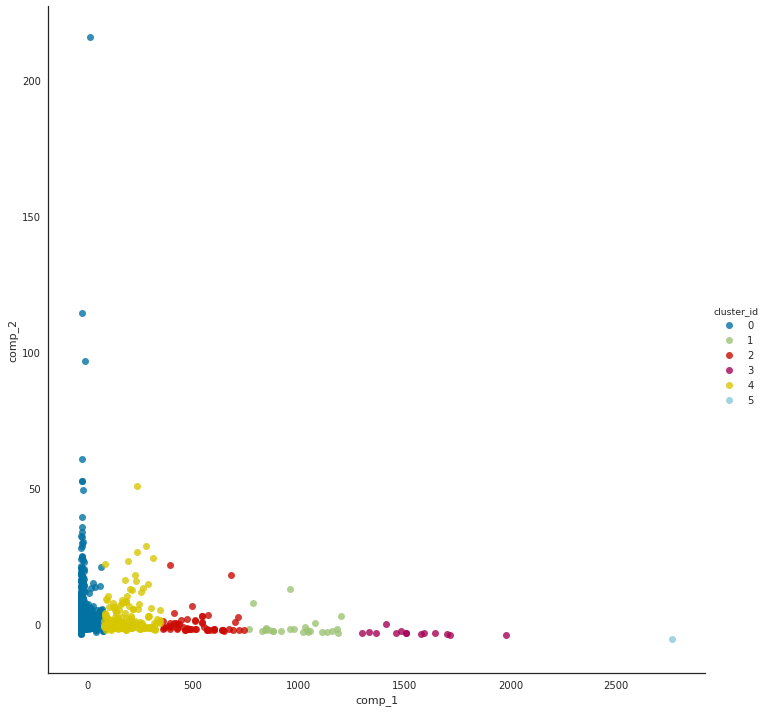

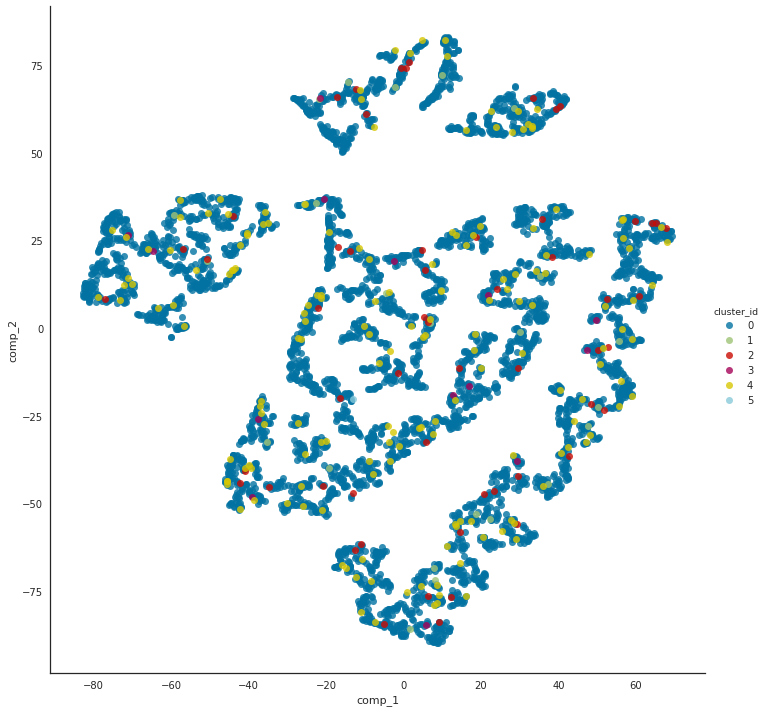

In [238]:
# Применим 2 других алгоритма кластеризации (AgglomerativeClustering и KMeans)
# с различным кол-во кластеров, получим основные хар-ки кластеров и визуализируем
# на данных после понижения размерности (PCA и TSNE)
cluster_grid = [{'clustering': [AgglomerativeClustering()],
                 'clustering__n_clusters': [2, 4, 6]},
                {'clustering': [KMeans()],
                 'clustering__n_clusters': [2, 4, 6],
                 'clustering__random_state': [random_state]}]
cluster_param_grid = ParameterGrid(cluster_grid)

for cluster_params in cluster_param_grid:
    cluster_pipeline.set_params(**cluster_params)
    cluster_labels = cluster_pipeline.fit_predict(prod_processed_data)
    cluster_model = cluster_pipeline.named_steps['clustering']
    print(cluster_model)
    
    cluster_df[cluster_label] = cluster_labels
    cluster_members_df = cluster_df.groupby(cluster_label).head(2).sort_values(cluster_label)
    display(HTML(cluster_members_df.to_html()))
    
    cluster_info_df = cluster_df.groupby(cluster_label)[prod_columns].mean()
    cluster_info_df['count'] = cluster_df[cluster_label].value_counts().sort_index()
    display(HTML(cluster_info_df.to_html()))
    
#     if type(cluster_model).__name__ == 'KMeans':
#         visualizer = SilhouetteVisualizer(cluster_model)
#         visualizer.fit(rfm_processed_data) 
#         visualizer.poof()
        
    pca_components_df = pd.DataFrame(pca_model.components_, columns=prod_columns, index=pca_columns)
    display(HTML(pca_components_df.to_html()))
    
    pca_data[cluster_label] = cluster_labels
    sns.lmplot('comp_1', 'comp_2', data=pca_data, hue=cluster_label, fit_reg=False, size=10)
    plt.show()
    
    tsne_data[cluster_label] = cluster_labels
    sns.lmplot('comp_1', 'comp_2', data=tsne_data, hue=cluster_label, fit_reg=False, size=10)
    plt.show()

**Выводы**  
По результатам кластеризации с понижением размерности PCA, можно увидеть, что на основе используемых признаков, больше всего на кластеризацию и визуализацию влияет кол-во чеков, где присутствует продукт (order_count).  
Визуализация на основе TSNE с текущими параметрами не смогла выделить кластеры на графике.

# Выводы

- Эвристика по DBSCAN во всех 3 типах сегментации позволяет найти параметры скорее для поиска выбросов, чем для кластеризации
- Визуализация на основе понижения размерности PCA в данном случае позволила отобразить кластеры более интерпретируемыми
- Необходима дальнейшая работа по каждому из типов сегментации
    - Создание и использование дополнительных признаков
    - Более тонкая настройка параметров для кластеризации
        - DBSCAN
            - eps, min_samples - используя другие эвристики, или путем перебора значений
        - KMeans, AgglomerativeClustering
            - n_clusters - используя метрики качества и их визуализацию, например, silhoette plot для оценки качестве кластеров на основе метрики silhouette
    - Более тонкая настройка параметров для понижения размерности
        - TSNE
            - perplexity, n_iter - используя перебор параметров и многократные запуски алгоритма с визуализацией, для определения более точных параметров
    - Определить параметры, по которым можно делать более репрезентативную выборку
        